In [1]:
import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/code/modules/'
import sys
sys.path.append(module_path)
fig_dir = 'figures/'
import time
import importlib
import random
import tensorflow as tf
import pandas as pd
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, concatenate
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
#import model_management
from scipy.special import comb
import datetime
import codecs, json
from itertools import combinations
%load_ext autoreload
%autoreload 1
%aimport environmental_density
%aimport data_processing
%aimport plotting
%aimport keras_objects
from environmental_density import *
from data_processing import *
from plotting import *
from keras_objects import *

np.random.seed(999)
random.seed(999)

#loss_func_dict = {
#    'mse': 'mse',
#    'mae': 'mae',
#    'weighted_mse_1': weighted_mse_1,
#    'stellar_mass_weighted_mse': stellar_mass_weighted_mse
#}

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
### Run on CPU only
os.environ["CUDA_VISIBLE_DEVICES"] = ""

## Set parameter string

In [ ]:
### Set name ending with parameters for figures to be saved
param_string = 'nLayers_%d_nNeurons_%d_actFun_%s_lossFunc_%s_nTrainSamples_%d_nEpochs_%d_batchSize_%d' % (
    nLayers, neuronsPerLayer, activationFunction, loss_function, train_size, nEpochs, batchSize)
print(param_string)

In [ ]:
print(np.mean(y_test_norm, 0))
print(np.std(y_test_norm, 0))
print(np.min(x_test_norm, 0))
print(np.max(x_test_norm, 0))

In [ ]:
### Get a feel for the data
for i in range(len(input_features)):
    print(input_features[i],': min: %.2e, max: %.2e.' % (np.min(x_train[:,i]), np.max(x_train[:,i])))
for i in range(len(output_features)):
    print(output_features[i],': min: %.2e, max: %.2e.' % (np.min(y_train[:,i]), np.max(y_train[:,i])))

In [ ]:
### Visualisation for when we have 2 input features
%matplotlib notebook
input_feat_1 = 0
input_feat_2 = 1
output_feat = 1

fig = plt.figure(1, figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train_norm[:500,input_feat_1], x_train_norm[:500,input_feat_2], 
           y_train_norm[:500,output_feat])
ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_1]))
ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_2]))
ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[output_feat]))
plt.show()

## Load an existing model

In [ ]:
### Search for the model that you want
importlib.reload(model_management)
search_dict = {
    'training_method': 'backprop'
}
[model_dicts, description_dicts] = model_management.SearchModel(search_dict, get_hits=True)
print(description_dicts)
print('\n')
for key in model_dicts:
    print(key)
    print(model_dicts[key])
    print('\n')


In [ ]:
importlib.reload(model_management)
model, model_dict, description = model_management.LoadModel(search_dict, 1)

## Get the standard pictures

In [13]:
mode = 'train' # 'train', 'val, 'test'

1000/1000 [==============================] - 0s 60us/step


<function matplotlib.pyplot.show>

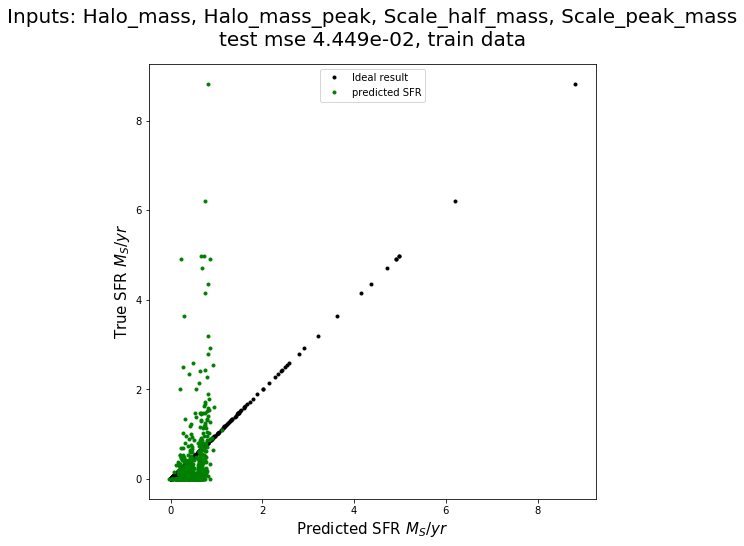

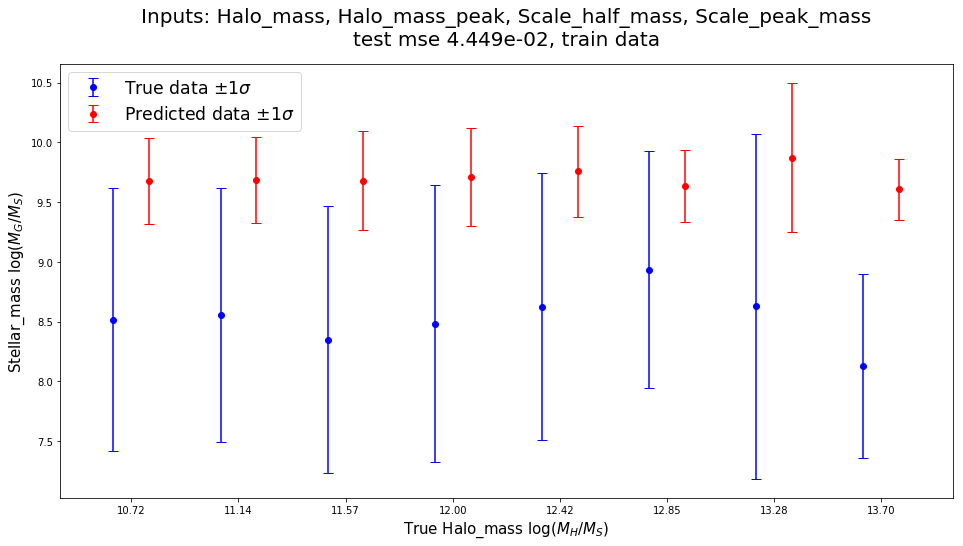

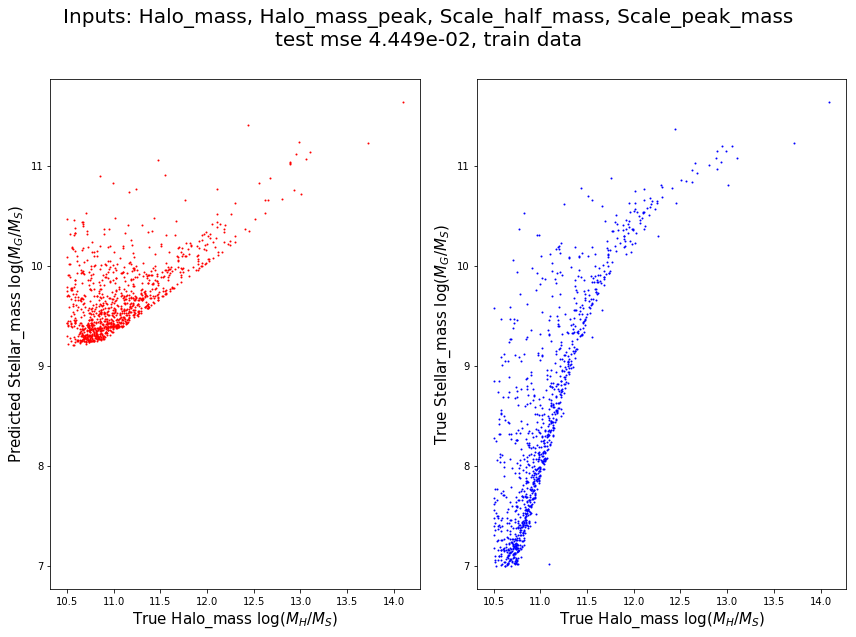

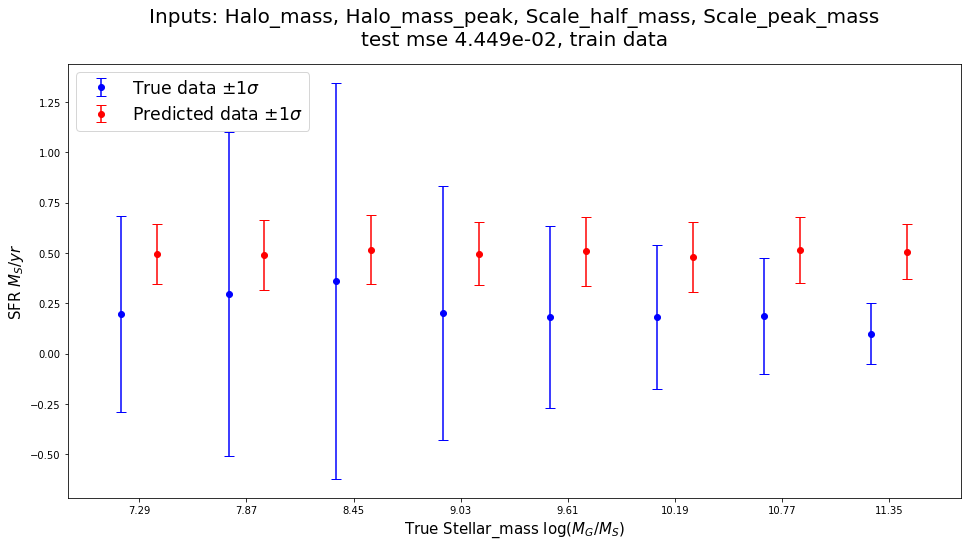

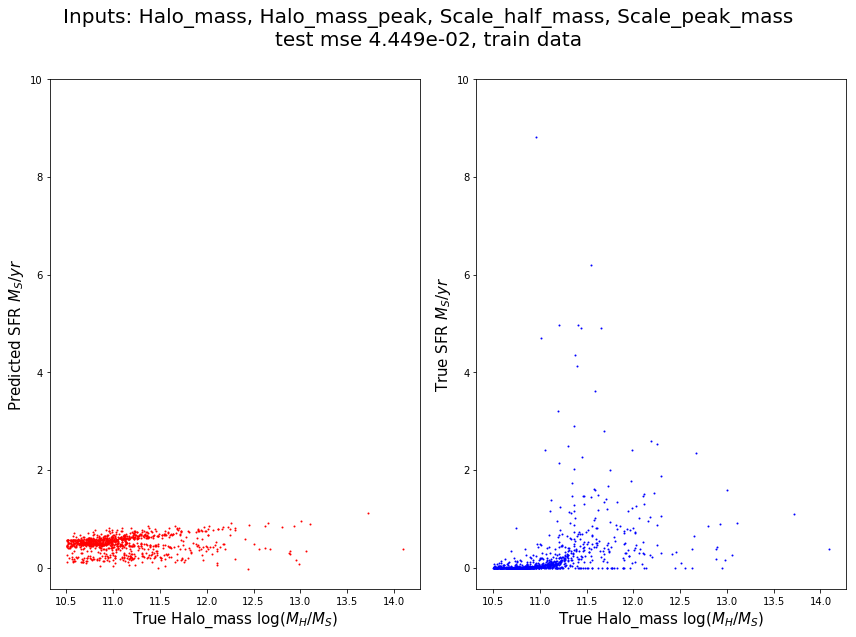

In [15]:
norm_scores = model.evaluate(x=training_data_dict['input_test_dict'], y=training_data_dict['output_test_dict'],
                                               verbose=1)
tot_score = norm_scores[0]
title = 'Inputs: %s\ntest mse %.3e, %s data' % (', '.join(input_features), tot_score, mode)
fig1 = get_pred_vs_real_scatterplot(model, training_data_dict, unit_dict, data_keys, 'SFR', title=title, data_type=mode)
fig2 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, predicted_feat = 'Stellar_mass', 
                                binning_feat = 'Halo_mass', title=title, data_type=mode)
fig3 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Halo_mass', 
                                    y_axis_feature = 'Stellar_mass', title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, data_type=mode)
fig4 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, 'SFR', 
                                binning_feat = 'Stellar_mass', title=title, data_type=mode)
fig5 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Halo_mass', 
                                    y_axis_feature = 'SFR', title=title, y_max = 10, y_min = None,
                                    x_min = None, x_max = None, data_type=mode)

plt.show

In [ ]:
fig6 = get_real_vs_pred_same_fig(model, training_data_dict, unit_dict, x_axis_feature='Halo_mass', 
                                 y_axis_feature = 'Stellar_mass', title=title, data_type=mode, marker_size=5)
fig7 = get_real_vs_pred_same_fig(model, training_data_dict, unit_dict, x_axis_feature='Halo_mass', 
                                 y_axis_feature = 'SFR', title=title, data_type=mode, marker_size=5)
plt.show

In [ ]:
### Save the figures
fig1.savefig(fig_dir + '_'.join(input_features) + '_true_pred_sfr_scatter.png', bbox_inches = 'tight')
fig2.savefig(fig_dir + '_'.join(input_features) + '_boxplot_stellar_mass.png', bbox_inches = 'tight')
fig3.savefig(fig_dir + '_'.join(input_features) + '_scatter_comp_halo_vs_stellar_mass.png', bbox_inches = 'tight')
fig4.savefig(fig_dir + '_'.join(input_features) + '_boxplot_sfr.png', bbox_inches = 'tight')
fig5.savefig(fig_dir + '_'.join(input_features) + '_scatter_comp_stellar_mass_vs_sfr.png', bbox_inches = 'tight')

## Create a new model

In [3]:
### General parameters
nr_steps = 1e5
batch_size = 1e3
total_set_size = 3e3 # how many examples will be used for training+validation+testing
train_size = 1e3
val_size = 1e3
test_size = 1e3
norm = 'zero_mean_unit_std' # 'none',   'zero_mean_unit_std',   'zero_to_one'
input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_half_mass', 'Scale_peak_mass']
output_features = ['Stellar_mass', 'SFR']
weighted_output_features = ['Stellar_mass', 'SFR']

early_stop_patience = 2000
early_stop_monitor = 'val_loss'
early_stop_min_delta = 1e-16

nr_epochs = nr_steps * batch_size / train_size

validation_data = 'val' #'val' is normally used, use 'train' to check overfitting potential

### Network parameters
nLayers = 10
activationFunction = 'tanh'
neuronsPerLayer = 10
reg_strength = 0#1e-5


In [4]:
# load the selected galaxyfile
galaxies, data_keys, unit_dict = load_galfile()
    
# prepare the training data
training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, 
                                       int(total_set_size), int(train_size), int(val_size), int(test_size))
#galaxies = None
training_data_dict = normalise_data(training_data_dict, norm)

In [5]:
# Create model
halo_mass_input = Input(shape=(1,), name = 'halo_mass_input')
others_input = Input(shape=(len(input_features)-1,), name = 'others_input')

for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
    if i == 0:
        x = concatenate([halo_mass_input, others_input])
        #x = Dense(neuronsPerLayer, activation = activationFunction)(x)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(x)
        x = LeakyReLU(alpha = 0.1)(x)
    else:
        #x = Dense(neuronsPerLayer, activation = activationFunction)(x)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(x)
        x = LeakyReLU(alpha = 0.1)(x)
        
output_layers = []
for feat in output_features:
#    out_pre_act = Dense(1)(x)
#    output_layers.append(LeakyReLU(alpha = 0, name = feat)(out_pre_act))
    output_layers.append(Dense(1, kernel_regularizer=regularizers.l2(reg_strength), name = feat)(x))

model = Model([halo_mass_input, others_input], output_layers)
model.compile(optimizer = 'adam', loss = halo_mass_weighted_loss_wrapper(halo_mass_input))

earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, patience=early_stop_patience, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

history = model.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                    validation_data = (training_data_dict['input_'+validation_data+'_dict'], 
                    training_data_dict['output_'+validation_data+'_dict']), 
                    epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list)

Train on 1000 samples, validate on 1000 samples
Epoch 1/100000
1000/1000 [==============================] - 1s 708us/step - loss: 0.0082 - Stellar_mass_loss: 0.0079 - SFR_loss: 2.8377e-04 - val_loss: 0.0089 - val_Stellar_mass_loss: 0.0083 - val_SFR_loss: 6.1086e-04
Epoch 2/100000
1000/1000 [==============================] - 0s 12us/step - loss: 0.0081 - Stellar_mass_loss: 0.0078 - SFR_loss: 2.8596e-04 - val_loss: 0.0088 - val_Stellar_mass_loss: 0.0082 - val_SFR_loss: 6.1377e-04
Epoch 3/100000
1000/1000 [==============================] - 0s 11us/step - loss: 0.0080 - Stellar_mass_loss: 0.0078 - SFR_loss: 2.8713e-04 - val_loss: 0.0087 - val_Stellar_mass_loss: 0.0081 - val_SFR_loss: 6.1485e-04
Epoch 4/100000
1000/1000 [==============================] - 0s 10us/step - loss: 0.0080 - Stellar_mass_loss: 0.0077 - SFR_loss: 2.8753e-04 - val_loss: 0.0086 - val_Stellar_mass_loss: 0.0080 - val_SFR_loss: 6.1563e-04
Epoch 5/100000
1000/1000 [==============================] - 0s 11us/step - loss: 0.

Epoch 39/100000
1000/1000 [==============================] - 0s 12us/step - loss: 0.0050 - Stellar_mass_loss: 0.0049 - SFR_loss: 1.8506e-04 - val_loss: 0.0048 - val_Stellar_mass_loss: 0.0046 - val_SFR_loss: 2.5761e-04
Epoch 40/100000
1000/1000 [==============================] - 0s 12us/step - loss: 0.0048 - Stellar_mass_loss: 0.0047 - SFR_loss: 1.8088e-04 - val_loss: 0.0046 - val_Stellar_mass_loss: 0.0043 - val_SFR_loss: 2.3222e-04
Epoch 41/100000
1000/1000 [==============================] - 0s 13us/step - loss: 0.0046 - Stellar_mass_loss: 0.0045 - SFR_loss: 1.7728e-04 - val_loss: 0.0043 - val_Stellar_mass_loss: 0.0041 - val_SFR_loss: 2.0618e-04
Epoch 42/100000
1000/1000 [==============================] - 0s 12us/step - loss: 0.0044 - Stellar_mass_loss: 0.0042 - SFR_loss: 1.7451e-04 - val_loss: 0.0040 - val_Stellar_mass_loss: 0.0038 - val_SFR_loss: 1.7989e-04
Epoch 43/100000
1000/1000 [==============================] - 0s 11us/step - loss: 0.0042 - Stellar_mass_loss: 0.0040 - SFR_loss:

1000/1000 [==============================] - 0s 13us/step - loss: 1.8749e-04 - Stellar_mass_loss: 1.2225e-05 - SFR_loss: 1.7527e-04 - val_loss: 3.0254e-04 - val_Stellar_mass_loss: 1.4721e-04 - val_SFR_loss: 1.5533e-04
Epoch 76/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8460e-04 - Stellar_mass_loss: 1.0498e-05 - SFR_loss: 1.7410e-04 - val_loss: 2.9419e-04 - val_Stellar_mass_loss: 1.1152e-04 - val_SFR_loss: 1.8267e-04
Epoch 77/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8767e-04 - Stellar_mass_loss: 1.2848e-05 - SFR_loss: 1.7483e-04 - val_loss: 2.9331e-04 - val_Stellar_mass_loss: 8.5030e-05 - val_SFR_loss: 2.0828e-04
Epoch 78/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.9457e-04 - Stellar_mass_loss: 1.7763e-05 - SFR_loss: 1.7680e-04 - val_loss: 2.9764e-04 - val_Stellar_mass_loss: 6.6136e-05 - val_SFR_loss: 2.3151e-04
Epoch 79/100000
1000/1000 [==============================] - 0s 12us/step - loss

1000/1000 [==============================] - 0s 11us/step - loss: 1.8432e-04 - Stellar_mass_loss: 1.0154e-05 - SFR_loss: 1.7417e-04 - val_loss: 2.8946e-04 - val_Stellar_mass_loss: 1.3440e-04 - val_SFR_loss: 1.5507e-04
Epoch 111/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8448e-04 - Stellar_mass_loss: 1.0296e-05 - SFR_loss: 1.7419e-04 - val_loss: 2.8097e-04 - val_Stellar_mass_loss: 1.2774e-04 - val_SFR_loss: 1.5323e-04
Epoch 112/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8475e-04 - Stellar_mass_loss: 1.0541e-05 - SFR_loss: 1.7421e-04 - val_loss: 2.7407e-04 - val_Stellar_mass_loss: 1.2251e-04 - val_SFR_loss: 1.5155e-04
Epoch 113/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.8506e-04 - Stellar_mass_loss: 1.0817e-05 - SFR_loss: 1.7425e-04 - val_loss: 2.6870e-04 - val_Stellar_mass_loss: 1.1868e-04 - val_SFR_loss: 1.5002e-04
Epoch 114/100000
1000/1000 [==============================] - 0s 11us/step - 

Epoch 145/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8391e-04 - Stellar_mass_loss: 9.6560e-06 - SFR_loss: 1.7426e-04 - val_loss: 2.9846e-04 - val_Stellar_mass_loss: 1.3456e-04 - val_SFR_loss: 1.6390e-04
Epoch 146/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.8391e-04 - Stellar_mass_loss: 9.6450e-06 - SFR_loss: 1.7426e-04 - val_loss: 2.9869e-04 - val_Stellar_mass_loss: 1.3440e-04 - val_SFR_loss: 1.6429e-04
Epoch 147/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8390e-04 - Stellar_mass_loss: 9.6303e-06 - SFR_loss: 1.7427e-04 - val_loss: 2.9904e-04 - val_Stellar_mass_loss: 1.3449e-04 - val_SFR_loss: 1.6455e-04
Epoch 148/100000
1000/1000 [==============================] - 0s 14us/step - loss: 1.8388e-04 - Stellar_mass_loss: 9.6121e-06 - SFR_loss: 1.7427e-04 - val_loss: 2.9949e-04 - val_Stellar_mass_loss: 1.3481e-04 - val_SFR_loss: 1.6468e-04
Epoch 149/100000
1000/1000 [==============================] 

Epoch 180/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8339e-04 - Stellar_mass_loss: 9.1998e-06 - SFR_loss: 1.7419e-04 - val_loss: 2.9503e-04 - val_Stellar_mass_loss: 1.3557e-04 - val_SFR_loss: 1.5946e-04
Epoch 181/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8337e-04 - Stellar_mass_loss: 9.1893e-06 - SFR_loss: 1.7418e-04 - val_loss: 2.9519e-04 - val_Stellar_mass_loss: 1.3572e-04 - val_SFR_loss: 1.5947e-04
Epoch 182/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.8336e-04 - Stellar_mass_loss: 9.1789e-06 - SFR_loss: 1.7418e-04 - val_loss: 2.9535e-04 - val_Stellar_mass_loss: 1.3586e-04 - val_SFR_loss: 1.5949e-04
Epoch 183/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.8335e-04 - Stellar_mass_loss: 9.1686e-06 - SFR_loss: 1.7418e-04 - val_loss: 2.9549e-04 - val_Stellar_mass_loss: 1.3596e-04 - val_SFR_loss: 1.5953e-04
Epoch 184/100000
1000/1000 [==============================] 

Epoch 215/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8288e-04 - Stellar_mass_loss: 8.8283e-06 - SFR_loss: 1.7406e-04 - val_loss: 2.9506e-04 - val_Stellar_mass_loss: 1.3383e-04 - val_SFR_loss: 1.6123e-04
Epoch 216/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8287e-04 - Stellar_mass_loss: 8.8173e-06 - SFR_loss: 1.7405e-04 - val_loss: 2.9497e-04 - val_Stellar_mass_loss: 1.3374e-04 - val_SFR_loss: 1.6123e-04
Epoch 217/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8285e-04 - Stellar_mass_loss: 8.8063e-06 - SFR_loss: 1.7405e-04 - val_loss: 2.9489e-04 - val_Stellar_mass_loss: 1.3364e-04 - val_SFR_loss: 1.6124e-04
Epoch 218/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8284e-04 - Stellar_mass_loss: 8.7953e-06 - SFR_loss: 1.7404e-04 - val_loss: 2.9479e-04 - val_Stellar_mass_loss: 1.3354e-04 - val_SFR_loss: 1.6125e-04
Epoch 219/100000
1000/1000 [==============================] 

Epoch 250/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8233e-04 - Stellar_mass_loss: 8.4337e-06 - SFR_loss: 1.7390e-04 - val_loss: 2.9316e-04 - val_Stellar_mass_loss: 1.3124e-04 - val_SFR_loss: 1.6192e-04
Epoch 251/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8232e-04 - Stellar_mass_loss: 8.4221e-06 - SFR_loss: 1.7389e-04 - val_loss: 2.9312e-04 - val_Stellar_mass_loss: 1.3117e-04 - val_SFR_loss: 1.6195e-04
Epoch 252/100000
1000/1000 [==============================] - 0s 18us/step - loss: 1.8230e-04 - Stellar_mass_loss: 8.4105e-06 - SFR_loss: 1.7389e-04 - val_loss: 2.9307e-04 - val_Stellar_mass_loss: 1.3110e-04 - val_SFR_loss: 1.6197e-04
Epoch 253/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8228e-04 - Stellar_mass_loss: 8.3988e-06 - SFR_loss: 1.7388e-04 - val_loss: 2.9303e-04 - val_Stellar_mass_loss: 1.3103e-04 - val_SFR_loss: 1.6199e-04
Epoch 254/100000
1000/1000 [==============================] 

Epoch 285/100000
1000/1000 [==============================] - 0s 14us/step - loss: 1.8173e-04 - Stellar_mass_loss: 8.0247e-06 - SFR_loss: 1.7370e-04 - val_loss: 2.9158e-04 - val_Stellar_mass_loss: 1.2882e-04 - val_SFR_loss: 1.6276e-04
Epoch 286/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.8171e-04 - Stellar_mass_loss: 8.0120e-06 - SFR_loss: 1.7370e-04 - val_loss: 2.9153e-04 - val_Stellar_mass_loss: 1.2875e-04 - val_SFR_loss: 1.6278e-04
Epoch 287/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8169e-04 - Stellar_mass_loss: 7.9993e-06 - SFR_loss: 1.7369e-04 - val_loss: 2.9148e-04 - val_Stellar_mass_loss: 1.2867e-04 - val_SFR_loss: 1.6281e-04
Epoch 288/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.8167e-04 - Stellar_mass_loss: 7.9866e-06 - SFR_loss: 1.7368e-04 - val_loss: 2.9143e-04 - val_Stellar_mass_loss: 1.2859e-04 - val_SFR_loss: 1.6283e-04
Epoch 289/100000
1000/1000 [==============================] 

Epoch 320/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8102e-04 - Stellar_mass_loss: 7.5678e-06 - SFR_loss: 1.7345e-04 - val_loss: 2.8976e-04 - val_Stellar_mass_loss: 1.2613e-04 - val_SFR_loss: 1.6363e-04
Epoch 321/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8100e-04 - Stellar_mass_loss: 7.5545e-06 - SFR_loss: 1.7344e-04 - val_loss: 2.8973e-04 - val_Stellar_mass_loss: 1.2608e-04 - val_SFR_loss: 1.6365e-04
Epoch 322/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.8098e-04 - Stellar_mass_loss: 7.5411e-06 - SFR_loss: 1.7344e-04 - val_loss: 2.8968e-04 - val_Stellar_mass_loss: 1.2601e-04 - val_SFR_loss: 1.6367e-04
Epoch 323/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8096e-04 - Stellar_mass_loss: 7.5276e-06 - SFR_loss: 1.7343e-04 - val_loss: 2.8964e-04 - val_Stellar_mass_loss: 1.2595e-04 - val_SFR_loss: 1.6369e-04
Epoch 324/100000
1000/1000 [==============================] 

Epoch 355/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8019e-04 - Stellar_mass_loss: 7.0623e-06 - SFR_loss: 1.7313e-04 - val_loss: 2.8779e-04 - val_Stellar_mass_loss: 1.2333e-04 - val_SFR_loss: 1.6446e-04
Epoch 356/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8017e-04 - Stellar_mass_loss: 7.0472e-06 - SFR_loss: 1.7312e-04 - val_loss: 2.8773e-04 - val_Stellar_mass_loss: 1.2325e-04 - val_SFR_loss: 1.6448e-04
Epoch 357/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8014e-04 - Stellar_mass_loss: 7.0320e-06 - SFR_loss: 1.7311e-04 - val_loss: 2.8766e-04 - val_Stellar_mass_loss: 1.2316e-04 - val_SFR_loss: 1.6451e-04
Epoch 358/100000
1000/1000 [==============================] - 0s 14us/step - loss: 1.8012e-04 - Stellar_mass_loss: 7.0168e-06 - SFR_loss: 1.7310e-04 - val_loss: 2.8760e-04 - val_Stellar_mass_loss: 1.2307e-04 - val_SFR_loss: 1.6453e-04
Epoch 359/100000
1000/1000 [==============================] 

Epoch 390/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7922e-04 - Stellar_mass_loss: 6.4996e-06 - SFR_loss: 1.7272e-04 - val_loss: 2.8561e-04 - val_Stellar_mass_loss: 1.2034e-04 - val_SFR_loss: 1.6527e-04
Epoch 391/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7919e-04 - Stellar_mass_loss: 6.4830e-06 - SFR_loss: 1.7271e-04 - val_loss: 2.8555e-04 - val_Stellar_mass_loss: 1.2026e-04 - val_SFR_loss: 1.6529e-04
Epoch 392/100000
1000/1000 [==============================] - 0s 15us/step - loss: 1.7916e-04 - Stellar_mass_loss: 6.4661e-06 - SFR_loss: 1.7269e-04 - val_loss: 2.8549e-04 - val_Stellar_mass_loss: 1.2018e-04 - val_SFR_loss: 1.6531e-04
Epoch 393/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.7913e-04 - Stellar_mass_loss: 6.4492e-06 - SFR_loss: 1.7268e-04 - val_loss: 2.8542e-04 - val_Stellar_mass_loss: 1.2009e-04 - val_SFR_loss: 1.6533e-04
Epoch 394/100000
1000/1000 [==============================] 

Epoch 425/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7810e-04 - Stellar_mass_loss: 5.8794e-06 - SFR_loss: 1.7222e-04 - val_loss: 2.8203e-04 - val_Stellar_mass_loss: 1.1589e-04 - val_SFR_loss: 1.6614e-04
Epoch 426/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7807e-04 - Stellar_mass_loss: 5.8624e-06 - SFR_loss: 1.7220e-04 - val_loss: 2.8172e-04 - val_Stellar_mass_loss: 1.1553e-04 - val_SFR_loss: 1.6619e-04
Epoch 427/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7803e-04 - Stellar_mass_loss: 5.8459e-06 - SFR_loss: 1.7219e-04 - val_loss: 2.8143e-04 - val_Stellar_mass_loss: 1.1519e-04 - val_SFR_loss: 1.6625e-04
Epoch 428/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7800e-04 - Stellar_mass_loss: 5.8299e-06 - SFR_loss: 1.7217e-04 - val_loss: 2.8117e-04 - val_Stellar_mass_loss: 1.1488e-04 - val_SFR_loss: 1.6629e-04
Epoch 429/100000
1000/1000 [==============================] 

Epoch 460/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.7576e-04 - Stellar_mass_loss: 4.9495e-06 - SFR_loss: 1.7081e-04 - val_loss: 2.5757e-04 - val_Stellar_mass_loss: 9.0834e-05 - val_SFR_loss: 1.6674e-04
Epoch 461/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.7566e-04 - Stellar_mass_loss: 4.9234e-06 - SFR_loss: 1.7074e-04 - val_loss: 2.5640e-04 - val_Stellar_mass_loss: 8.9686e-05 - val_SFR_loss: 1.6671e-04
Epoch 462/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.7557e-04 - Stellar_mass_loss: 4.8977e-06 - SFR_loss: 1.7067e-04 - val_loss: 2.5519e-04 - val_Stellar_mass_loss: 8.8504e-05 - val_SFR_loss: 1.6669e-04
Epoch 463/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7547e-04 - Stellar_mass_loss: 4.8732e-06 - SFR_loss: 1.7060e-04 - val_loss: 2.5396e-04 - val_Stellar_mass_loss: 8.7309e-05 - val_SFR_loss: 1.6666e-04
Epoch 464/100000
1000/1000 [==============================] 

Epoch 495/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7116e-04 - Stellar_mass_loss: 4.5525e-06 - SFR_loss: 1.6660e-04 - val_loss: 2.4216e-04 - val_Stellar_mass_loss: 8.0281e-05 - val_SFR_loss: 1.6188e-04
Epoch 496/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.7097e-04 - Stellar_mass_loss: 4.5522e-06 - SFR_loss: 1.6642e-04 - val_loss: 2.4221e-04 - val_Stellar_mass_loss: 8.0716e-05 - val_SFR_loss: 1.6149e-04
Epoch 497/100000
1000/1000 [==============================] - 0s 14us/step - loss: 1.7078e-04 - Stellar_mass_loss: 4.5527e-06 - SFR_loss: 1.6622e-04 - val_loss: 2.4225e-04 - val_Stellar_mass_loss: 8.1129e-05 - val_SFR_loss: 1.6113e-04
Epoch 498/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.7058e-04 - Stellar_mass_loss: 4.5541e-06 - SFR_loss: 1.6602e-04 - val_loss: 2.4220e-04 - val_Stellar_mass_loss: 8.1439e-05 - val_SFR_loss: 1.6076e-04
Epoch 499/100000
1000/1000 [==============================] 

Epoch 530/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.6121e-04 - Stellar_mass_loss: 4.7025e-06 - SFR_loss: 1.5651e-04 - val_loss: 2.4809e-04 - val_Stellar_mass_loss: 9.5432e-05 - val_SFR_loss: 1.5265e-04
Epoch 531/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.6078e-04 - Stellar_mass_loss: 4.7101e-06 - SFR_loss: 1.5607e-04 - val_loss: 2.4801e-04 - val_Stellar_mass_loss: 9.5816e-05 - val_SFR_loss: 1.5220e-04
Epoch 532/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.6034e-04 - Stellar_mass_loss: 4.7185e-06 - SFR_loss: 1.5562e-04 - val_loss: 2.4788e-04 - val_Stellar_mass_loss: 9.6189e-05 - val_SFR_loss: 1.5169e-04
Epoch 533/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.5990e-04 - Stellar_mass_loss: 4.7274e-06 - SFR_loss: 1.5517e-04 - val_loss: 2.4833e-04 - val_Stellar_mass_loss: 9.6924e-05 - val_SFR_loss: 1.5140e-04
Epoch 534/100000
1000/1000 [==============================] 

Epoch 565/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.4087e-04 - Stellar_mass_loss: 5.0444e-06 - SFR_loss: 1.3582e-04 - val_loss: 2.3111e-04 - val_Stellar_mass_loss: 1.0463e-04 - val_SFR_loss: 1.2648e-04
Epoch 566/100000
1000/1000 [==============================] - 0s 14us/step - loss: 1.4003e-04 - Stellar_mass_loss: 5.0574e-06 - SFR_loss: 1.3497e-04 - val_loss: 2.2951e-04 - val_Stellar_mass_loss: 1.0442e-04 - val_SFR_loss: 1.2510e-04
Epoch 567/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.3908e-04 - Stellar_mass_loss: 5.0560e-06 - SFR_loss: 1.3402e-04 - val_loss: 2.2759e-04 - val_Stellar_mass_loss: 1.0395e-04 - val_SFR_loss: 1.2364e-04
Epoch 568/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.3817e-04 - Stellar_mass_loss: 5.0555e-06 - SFR_loss: 1.3312e-04 - val_loss: 2.2656e-04 - val_Stellar_mass_loss: 1.0382e-04 - val_SFR_loss: 1.2274e-04
Epoch 569/100000
1000/1000 [==============================] 

Epoch 600/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.0073e-04 - Stellar_mass_loss: 5.5317e-06 - SFR_loss: 9.5193e-05 - val_loss: 1.9610e-04 - val_Stellar_mass_loss: 1.1231e-04 - val_SFR_loss: 8.3791e-05
Epoch 601/100000
1000/1000 [==============================] - 0s 13us/step - loss: 9.9412e-05 - Stellar_mass_loss: 5.5670e-06 - SFR_loss: 9.3846e-05 - val_loss: 1.9290e-04 - val_Stellar_mass_loss: 1.1249e-04 - val_SFR_loss: 8.0405e-05
Epoch 602/100000
1000/1000 [==============================] - 0s 13us/step - loss: 9.8055e-05 - Stellar_mass_loss: 5.6026e-06 - SFR_loss: 9.2453e-05 - val_loss: 1.9208e-04 - val_Stellar_mass_loss: 1.1316e-04 - val_SFR_loss: 7.8918e-05
Epoch 603/100000
1000/1000 [==============================] - 0s 12us/step - loss: 9.6639e-05 - Stellar_mass_loss: 5.6327e-06 - SFR_loss: 9.1007e-05 - val_loss: 1.9165e-04 - val_Stellar_mass_loss: 1.1382e-04 - val_SFR_loss: 7.7826e-05
Epoch 604/100000
1000/1000 [==============================] 

Epoch 635/100000
1000/1000 [==============================] - 0s 10us/step - loss: 5.0615e-05 - Stellar_mass_loss: 5.7573e-06 - SFR_loss: 4.4858e-05 - val_loss: 1.2376e-04 - val_Stellar_mass_loss: 1.0426e-04 - val_SFR_loss: 1.9507e-05
Epoch 636/100000
1000/1000 [==============================] - 0s 10us/step - loss: 4.9361e-05 - Stellar_mass_loss: 5.7451e-06 - SFR_loss: 4.3616e-05 - val_loss: 1.2194e-04 - val_Stellar_mass_loss: 1.0387e-04 - val_SFR_loss: 1.8080e-05
Epoch 637/100000
1000/1000 [==============================] - 0s 11us/step - loss: 4.8163e-05 - Stellar_mass_loss: 5.7329e-06 - SFR_loss: 4.2430e-05 - val_loss: 1.1969e-04 - val_Stellar_mass_loss: 1.0328e-04 - val_SFR_loss: 1.6407e-05
Epoch 638/100000
1000/1000 [==============================] - 0s 11us/step - loss: 4.6961e-05 - Stellar_mass_loss: 5.7204e-06 - SFR_loss: 4.1241e-05 - val_loss: 1.1709e-04 - val_Stellar_mass_loss: 1.0253e-04 - val_SFR_loss: 1.4561e-05
Epoch 639/100000
1000/1000 [==============================] 

Epoch 670/100000
1000/1000 [==============================] - 0s 12us/step - loss: 2.6845e-05 - Stellar_mass_loss: 4.1384e-06 - SFR_loss: 2.2707e-05 - val_loss: 7.7825e-05 - val_Stellar_mass_loss: 7.2622e-05 - val_SFR_loss: 5.2029e-06
Epoch 671/100000
1000/1000 [==============================] - 0s 11us/step - loss: 2.6657e-05 - Stellar_mass_loss: 4.0952e-06 - SFR_loss: 2.2562e-05 - val_loss: 7.7316e-05 - val_Stellar_mass_loss: 7.1715e-05 - val_SFR_loss: 5.6011e-06
Epoch 672/100000
1000/1000 [==============================] - 0s 12us/step - loss: 2.6482e-05 - Stellar_mass_loss: 4.0539e-06 - SFR_loss: 2.2429e-05 - val_loss: 7.6828e-05 - val_Stellar_mass_loss: 7.0849e-05 - val_SFR_loss: 5.9791e-06
Epoch 673/100000
1000/1000 [==============================] - 0s 12us/step - loss: 2.6321e-05 - Stellar_mass_loss: 4.0145e-06 - SFR_loss: 2.2307e-05 - val_loss: 7.6357e-05 - val_Stellar_mass_loss: 7.0018e-05 - val_SFR_loss: 6.3391e-06
Epoch 674/100000
1000/1000 [==============================] 

Epoch 705/100000
1000/1000 [==============================] - 0s 12us/step - loss: 2.4303e-05 - Stellar_mass_loss: 3.5034e-06 - SFR_loss: 2.0799e-05 - val_loss: 7.6891e-05 - val_Stellar_mass_loss: 5.4129e-05 - val_SFR_loss: 2.2763e-05
Epoch 706/100000
1000/1000 [==============================] - 0s 14us/step - loss: 2.4265e-05 - Stellar_mass_loss: 3.4964e-06 - SFR_loss: 2.0769e-05 - val_loss: 7.7289e-05 - val_Stellar_mass_loss: 5.3939e-05 - val_SFR_loss: 2.3350e-05
Epoch 707/100000
1000/1000 [==============================] - 0s 10us/step - loss: 2.4227e-05 - Stellar_mass_loss: 3.4895e-06 - SFR_loss: 2.0738e-05 - val_loss: 7.7681e-05 - val_Stellar_mass_loss: 5.3768e-05 - val_SFR_loss: 2.3912e-05
Epoch 708/100000
1000/1000 [==============================] - 0s 12us/step - loss: 2.4189e-05 - Stellar_mass_loss: 3.4825e-06 - SFR_loss: 2.0706e-05 - val_loss: 7.8069e-05 - val_Stellar_mass_loss: 5.3610e-05 - val_SFR_loss: 2.4459e-05
Epoch 709/100000
1000/1000 [==============================] 

Epoch 740/100000
1000/1000 [==============================] - 0s 13us/step - loss: 2.3105e-05 - Stellar_mass_loss: 3.3261e-06 - SFR_loss: 1.9778e-05 - val_loss: 9.6072e-05 - val_Stellar_mass_loss: 4.9060e-05 - val_SFR_loss: 4.7012e-05
Epoch 741/100000
1000/1000 [==============================] - 0s 13us/step - loss: 2.3072e-05 - Stellar_mass_loss: 3.3218e-06 - SFR_loss: 1.9750e-05 - val_loss: 9.6761e-05 - val_Stellar_mass_loss: 4.8903e-05 - val_SFR_loss: 4.7858e-05
Epoch 742/100000
1000/1000 [==============================] - 0s 12us/step - loss: 2.3039e-05 - Stellar_mass_loss: 3.3174e-06 - SFR_loss: 1.9722e-05 - val_loss: 9.7455e-05 - val_Stellar_mass_loss: 4.8744e-05 - val_SFR_loss: 4.8710e-05
Epoch 743/100000
1000/1000 [==============================] - 0s 12us/step - loss: 2.3007e-05 - Stellar_mass_loss: 3.3130e-06 - SFR_loss: 1.9694e-05 - val_loss: 9.8156e-05 - val_Stellar_mass_loss: 4.8584e-05 - val_SFR_loss: 4.9572e-05
Epoch 744/100000
1000/1000 [==============================] 

Epoch 775/100000
1000/1000 [==============================] - 0s 11us/step - loss: 2.2270e-05 - Stellar_mass_loss: 3.1572e-06 - SFR_loss: 1.9113e-05 - val_loss: 1.2004e-04 - val_Stellar_mass_loss: 4.6174e-05 - val_SFR_loss: 7.3863e-05
Epoch 776/100000
1000/1000 [==============================] - 0s 10us/step - loss: 2.2251e-05 - Stellar_mass_loss: 3.1519e-06 - SFR_loss: 1.9099e-05 - val_loss: 1.2082e-04 - val_Stellar_mass_loss: 4.6141e-05 - val_SFR_loss: 7.4682e-05
Epoch 777/100000
1000/1000 [==============================] - 0s 10us/step - loss: 2.2232e-05 - Stellar_mass_loss: 3.1466e-06 - SFR_loss: 1.9086e-05 - val_loss: 1.2156e-04 - val_Stellar_mass_loss: 4.6116e-05 - val_SFR_loss: 7.5440e-05
Epoch 778/100000
1000/1000 [==============================] - 0s 10us/step - loss: 2.2214e-05 - Stellar_mass_loss: 3.1414e-06 - SFR_loss: 1.9072e-05 - val_loss: 1.2221e-04 - val_Stellar_mass_loss: 4.6103e-05 - val_SFR_loss: 7.6105e-05
Epoch 779/100000
1000/1000 [==============================] 

Epoch 810/100000
1000/1000 [==============================] - 0s 11us/step - loss: 2.1734e-05 - Stellar_mass_loss: 2.9946e-06 - SFR_loss: 1.8740e-05 - val_loss: 1.4234e-04 - val_Stellar_mass_loss: 4.6178e-05 - val_SFR_loss: 9.6165e-05
Epoch 811/100000
1000/1000 [==============================] - 0s 10us/step - loss: 2.1723e-05 - Stellar_mass_loss: 2.9903e-06 - SFR_loss: 1.8732e-05 - val_loss: 1.4304e-04 - val_Stellar_mass_loss: 4.6104e-05 - val_SFR_loss: 9.6940e-05
Epoch 812/100000
1000/1000 [==============================] - 0s 11us/step - loss: 2.1711e-05 - Stellar_mass_loss: 2.9861e-06 - SFR_loss: 1.8725e-05 - val_loss: 1.4368e-04 - val_Stellar_mass_loss: 4.6025e-05 - val_SFR_loss: 9.7654e-05
Epoch 813/100000
1000/1000 [==============================] - 0s 12us/step - loss: 2.1700e-05 - Stellar_mass_loss: 2.9821e-06 - SFR_loss: 1.8718e-05 - val_loss: 1.4418e-04 - val_Stellar_mass_loss: 4.5955e-05 - val_SFR_loss: 9.8223e-05
Epoch 814/100000
1000/1000 [==============================] 

Epoch 845/100000
1000/1000 [==============================] - 0s 13us/step - loss: 2.1359e-05 - Stellar_mass_loss: 2.8705e-06 - SFR_loss: 1.8488e-05 - val_loss: 1.6007e-04 - val_Stellar_mass_loss: 4.4121e-05 - val_SFR_loss: 1.1595e-04
Epoch 846/100000
1000/1000 [==============================] - 0s 11us/step - loss: 2.1348e-05 - Stellar_mass_loss: 2.8672e-06 - SFR_loss: 1.8481e-05 - val_loss: 1.6059e-04 - val_Stellar_mass_loss: 4.4082e-05 - val_SFR_loss: 1.1651e-04
Epoch 847/100000
1000/1000 [==============================] - 0s 11us/step - loss: 2.1338e-05 - Stellar_mass_loss: 2.8638e-06 - SFR_loss: 1.8474e-05 - val_loss: 1.6115e-04 - val_Stellar_mass_loss: 4.4036e-05 - val_SFR_loss: 1.1711e-04
Epoch 848/100000
1000/1000 [==============================] - 0s 13us/step - loss: 2.1327e-05 - Stellar_mass_loss: 2.8604e-06 - SFR_loss: 1.8467e-05 - val_loss: 1.6173e-04 - val_Stellar_mass_loss: 4.3985e-05 - val_SFR_loss: 1.1775e-04
Epoch 849/100000
1000/1000 [==============================] 

Epoch 880/100000
1000/1000 [==============================] - 0s 11us/step - loss: 2.1036e-05 - Stellar_mass_loss: 2.7579e-06 - SFR_loss: 1.8278e-05 - val_loss: 1.7783e-04 - val_Stellar_mass_loss: 4.3040e-05 - val_SFR_loss: 1.3479e-04
Epoch 881/100000
1000/1000 [==============================] - 0s 11us/step - loss: 2.1028e-05 - Stellar_mass_loss: 2.7546e-06 - SFR_loss: 1.8273e-05 - val_loss: 1.7826e-04 - val_Stellar_mass_loss: 4.3019e-05 - val_SFR_loss: 1.3524e-04
Epoch 882/100000
1000/1000 [==============================] - 0s 11us/step - loss: 2.1019e-05 - Stellar_mass_loss: 2.7514e-06 - SFR_loss: 1.8268e-05 - val_loss: 1.7869e-04 - val_Stellar_mass_loss: 4.2995e-05 - val_SFR_loss: 1.3570e-04
Epoch 883/100000
1000/1000 [==============================] - 0s 11us/step - loss: 2.1012e-05 - Stellar_mass_loss: 2.7482e-06 - SFR_loss: 1.8263e-05 - val_loss: 1.7912e-04 - val_Stellar_mass_loss: 4.2972e-05 - val_SFR_loss: 1.3615e-04
Epoch 884/100000
1000/1000 [==============================] 

Epoch 915/100000
1000/1000 [==============================] - 0s 11us/step - loss: 2.0779e-05 - Stellar_mass_loss: 2.6561e-06 - SFR_loss: 1.8123e-05 - val_loss: 1.9473e-04 - val_Stellar_mass_loss: 4.1593e-05 - val_SFR_loss: 1.5314e-04
Epoch 916/100000
1000/1000 [==============================] - 0s 13us/step - loss: 2.0773e-05 - Stellar_mass_loss: 2.6535e-06 - SFR_loss: 1.8119e-05 - val_loss: 1.9531e-04 - val_Stellar_mass_loss: 4.1626e-05 - val_SFR_loss: 1.5369e-04
Epoch 917/100000
1000/1000 [==============================] - 0s 11us/step - loss: 2.0766e-05 - Stellar_mass_loss: 2.6516e-06 - SFR_loss: 1.8114e-05 - val_loss: 1.9550e-04 - val_Stellar_mass_loss: 4.1659e-05 - val_SFR_loss: 1.5384e-04
Epoch 918/100000
1000/1000 [==============================] - 0s 11us/step - loss: 2.0760e-05 - Stellar_mass_loss: 2.6499e-06 - SFR_loss: 1.8110e-05 - val_loss: 1.9655e-04 - val_Stellar_mass_loss: 4.1579e-05 - val_SFR_loss: 1.5498e-04
Epoch 919/100000
1000/1000 [==============================] 

Epoch 950/100000
1000/1000 [==============================] - 0s 13us/step - loss: 2.0548e-05 - Stellar_mass_loss: 2.5743e-06 - SFR_loss: 1.7974e-05 - val_loss: 2.1311e-04 - val_Stellar_mass_loss: 3.9989e-05 - val_SFR_loss: 1.7312e-04
Epoch 951/100000
1000/1000 [==============================] - 0s 11us/step - loss: 2.0545e-05 - Stellar_mass_loss: 2.5735e-06 - SFR_loss: 1.7972e-05 - val_loss: 2.1361e-04 - val_Stellar_mass_loss: 3.9950e-05 - val_SFR_loss: 1.7366e-04
Epoch 952/100000
1000/1000 [==============================] - 0s 10us/step - loss: 2.0540e-05 - Stellar_mass_loss: 2.5717e-06 - SFR_loss: 1.7968e-05 - val_loss: 2.1530e-04 - val_Stellar_mass_loss: 3.9800e-05 - val_SFR_loss: 1.7550e-04
Epoch 953/100000
1000/1000 [==============================] - 0s 10us/step - loss: 2.0529e-05 - Stellar_mass_loss: 2.5686e-06 - SFR_loss: 1.7961e-05 - val_loss: 2.1685e-04 - val_Stellar_mass_loss: 3.9649e-05 - val_SFR_loss: 1.7720e-04
Epoch 954/100000
1000/1000 [==============================] 

Epoch 985/100000
1000/1000 [==============================] - 0s 11us/step - loss: 2.0333e-05 - Stellar_mass_loss: 2.4991e-06 - SFR_loss: 1.7834e-05 - val_loss: 2.3492e-04 - val_Stellar_mass_loss: 3.8239e-05 - val_SFR_loss: 1.9668e-04
Epoch 986/100000
1000/1000 [==============================] - 0s 11us/step - loss: 2.0326e-05 - Stellar_mass_loss: 2.4975e-06 - SFR_loss: 1.7828e-05 - val_loss: 2.3462e-04 - val_Stellar_mass_loss: 3.8231e-05 - val_SFR_loss: 1.9639e-04
Epoch 987/100000
1000/1000 [==============================] - 0s 10us/step - loss: 2.0323e-05 - Stellar_mass_loss: 2.4960e-06 - SFR_loss: 1.7827e-05 - val_loss: 2.3556e-04 - val_Stellar_mass_loss: 3.8132e-05 - val_SFR_loss: 1.9743e-04
Epoch 988/100000
1000/1000 [==============================] - 0s 13us/step - loss: 2.0316e-05 - Stellar_mass_loss: 2.4936e-06 - SFR_loss: 1.7822e-05 - val_loss: 2.3757e-04 - val_Stellar_mass_loss: 3.7966e-05 - val_SFR_loss: 1.9960e-04
Epoch 989/100000
1000/1000 [==============================] 

Epoch 1020/100000
1000/1000 [==============================] - 0s 13us/step - loss: 2.0127e-05 - Stellar_mass_loss: 2.4290e-06 - SFR_loss: 1.7698e-05 - val_loss: 2.5717e-04 - val_Stellar_mass_loss: 3.6676e-05 - val_SFR_loss: 2.2050e-04
Epoch 1021/100000
1000/1000 [==============================] - 0s 15us/step - loss: 2.0120e-05 - Stellar_mass_loss: 2.4265e-06 - SFR_loss: 1.7694e-05 - val_loss: 2.5798e-04 - val_Stellar_mass_loss: 3.6615e-05 - val_SFR_loss: 2.2137e-04
Epoch 1022/100000
1000/1000 [==============================] - 0s 12us/step - loss: 2.0115e-05 - Stellar_mass_loss: 2.4244e-06 - SFR_loss: 1.7691e-05 - val_loss: 2.5753e-04 - val_Stellar_mass_loss: 3.6642e-05 - val_SFR_loss: 2.2089e-04
Epoch 1023/100000
1000/1000 [==============================] - 0s 13us/step - loss: 2.0108e-05 - Stellar_mass_loss: 2.4225e-06 - SFR_loss: 1.7685e-05 - val_loss: 2.5829e-04 - val_Stellar_mass_loss: 3.6628e-05 - val_SFR_loss: 2.2166e-04
Epoch 1024/100000
1000/1000 [===========================

Epoch 1055/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.9934e-05 - Stellar_mass_loss: 2.3611e-06 - SFR_loss: 1.7573e-05 - val_loss: 2.7827e-04 - val_Stellar_mass_loss: 3.5828e-05 - val_SFR_loss: 2.4244e-04
Epoch 1056/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.9928e-05 - Stellar_mass_loss: 2.3593e-06 - SFR_loss: 1.7568e-05 - val_loss: 2.7863e-04 - val_Stellar_mass_loss: 3.5864e-05 - val_SFR_loss: 2.4277e-04
Epoch 1057/100000
1000/1000 [==============================] - 0s 14us/step - loss: 1.9923e-05 - Stellar_mass_loss: 2.3579e-06 - SFR_loss: 1.7565e-05 - val_loss: 2.8029e-04 - val_Stellar_mass_loss: 3.5817e-05 - val_SFR_loss: 2.4447e-04
Epoch 1058/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.9920e-05 - Stellar_mass_loss: 2.3562e-06 - SFR_loss: 1.7563e-05 - val_loss: 2.8072e-04 - val_Stellar_mass_loss: 3.5806e-05 - val_SFR_loss: 2.4491e-04
Epoch 1059/100000
1000/1000 [===========================

Epoch 1090/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.9766e-05 - Stellar_mass_loss: 2.3045e-06 - SFR_loss: 1.7462e-05 - val_loss: 3.0105e-04 - val_Stellar_mass_loss: 3.4850e-05 - val_SFR_loss: 2.6620e-04
Epoch 1091/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.9762e-05 - Stellar_mass_loss: 2.3024e-06 - SFR_loss: 1.7459e-05 - val_loss: 3.0050e-04 - val_Stellar_mass_loss: 3.4895e-05 - val_SFR_loss: 2.6560e-04
Epoch 1092/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.9757e-05 - Stellar_mass_loss: 2.3013e-06 - SFR_loss: 1.7456e-05 - val_loss: 3.0107e-04 - val_Stellar_mass_loss: 3.4862e-05 - val_SFR_loss: 2.6621e-04
Epoch 1093/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.9753e-05 - Stellar_mass_loss: 2.3000e-06 - SFR_loss: 1.7453e-05 - val_loss: 3.0267e-04 - val_Stellar_mass_loss: 3.4754e-05 - val_SFR_loss: 2.6791e-04
Epoch 1094/100000
1000/1000 [===========================

Epoch 1125/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.9611e-05 - Stellar_mass_loss: 2.2506e-06 - SFR_loss: 1.7361e-05 - val_loss: 3.2218e-04 - val_Stellar_mass_loss: 3.4057e-05 - val_SFR_loss: 2.8813e-04
Epoch 1126/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.9606e-05 - Stellar_mass_loss: 2.2490e-06 - SFR_loss: 1.7357e-05 - val_loss: 3.2342e-04 - val_Stellar_mass_loss: 3.4015e-05 - val_SFR_loss: 2.8940e-04
Epoch 1127/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.9602e-05 - Stellar_mass_loss: 2.2474e-06 - SFR_loss: 1.7355e-05 - val_loss: 3.2356e-04 - val_Stellar_mass_loss: 3.4037e-05 - val_SFR_loss: 2.8953e-04
Epoch 1128/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.9597e-05 - Stellar_mass_loss: 2.2458e-06 - SFR_loss: 1.7352e-05 - val_loss: 3.2467e-04 - val_Stellar_mass_loss: 3.4036e-05 - val_SFR_loss: 2.9063e-04
Epoch 1129/100000
1000/1000 [===========================

Epoch 1160/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.9464e-05 - Stellar_mass_loss: 2.1969e-06 - SFR_loss: 1.7267e-05 - val_loss: 3.4597e-04 - val_Stellar_mass_loss: 3.3604e-05 - val_SFR_loss: 3.1237e-04
Epoch 1161/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.9464e-05 - Stellar_mass_loss: 2.1955e-06 - SFR_loss: 1.7268e-05 - val_loss: 3.4588e-04 - val_Stellar_mass_loss: 3.3601e-05 - val_SFR_loss: 3.1228e-04
Epoch 1162/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.9458e-05 - Stellar_mass_loss: 2.1944e-06 - SFR_loss: 1.7264e-05 - val_loss: 3.4427e-04 - val_Stellar_mass_loss: 3.3681e-05 - val_SFR_loss: 3.1059e-04
Epoch 1163/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.9454e-05 - Stellar_mass_loss: 2.1933e-06 - SFR_loss: 1.7261e-05 - val_loss: 3.4436e-04 - val_Stellar_mass_loss: 3.3704e-05 - val_SFR_loss: 3.1066e-04
Epoch 1164/100000
1000/1000 [===========================

Epoch 1195/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.9325e-05 - Stellar_mass_loss: 2.1448e-06 - SFR_loss: 1.7180e-05 - val_loss: 3.6506e-04 - val_Stellar_mass_loss: 3.3613e-05 - val_SFR_loss: 3.3144e-04
Epoch 1196/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.9322e-05 - Stellar_mass_loss: 2.1438e-06 - SFR_loss: 1.7178e-05 - val_loss: 3.6627e-04 - val_Stellar_mass_loss: 3.3670e-05 - val_SFR_loss: 3.3260e-04
Epoch 1197/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.9317e-05 - Stellar_mass_loss: 2.1424e-06 - SFR_loss: 1.7175e-05 - val_loss: 3.6881e-04 - val_Stellar_mass_loss: 3.3647e-05 - val_SFR_loss: 3.3516e-04
Epoch 1198/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.9318e-05 - Stellar_mass_loss: 2.1405e-06 - SFR_loss: 1.7177e-05 - val_loss: 3.6840e-04 - val_Stellar_mass_loss: 3.3684e-05 - val_SFR_loss: 3.3472e-04
Epoch 1199/100000
1000/1000 [===========================

Epoch 1230/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.9197e-05 - Stellar_mass_loss: 2.0947e-06 - SFR_loss: 1.7103e-05 - val_loss: 3.8339e-04 - val_Stellar_mass_loss: 3.3830e-05 - val_SFR_loss: 3.4956e-04
Epoch 1231/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.9197e-05 - Stellar_mass_loss: 2.0937e-06 - SFR_loss: 1.7103e-05 - val_loss: 3.8512e-04 - val_Stellar_mass_loss: 3.3819e-05 - val_SFR_loss: 3.5130e-04
Epoch 1232/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.9190e-05 - Stellar_mass_loss: 2.0916e-06 - SFR_loss: 1.7098e-05 - val_loss: 3.8831e-04 - val_Stellar_mass_loss: 3.3763e-05 - val_SFR_loss: 3.5455e-04
Epoch 1233/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.9184e-05 - Stellar_mass_loss: 2.0900e-06 - SFR_loss: 1.7094e-05 - val_loss: 3.8979e-04 - val_Stellar_mass_loss: 3.3760e-05 - val_SFR_loss: 3.5603e-04
Epoch 1234/100000
1000/1000 [===========================

Epoch 1265/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.9079e-05 - Stellar_mass_loss: 2.0445e-06 - SFR_loss: 1.7034e-05 - val_loss: 4.0168e-04 - val_Stellar_mass_loss: 3.3828e-05 - val_SFR_loss: 3.6785e-04
Epoch 1266/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.9070e-05 - Stellar_mass_loss: 2.0420e-06 - SFR_loss: 1.7028e-05 - val_loss: 4.0523e-04 - val_Stellar_mass_loss: 3.3710e-05 - val_SFR_loss: 3.7152e-04
Epoch 1267/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.9064e-05 - Stellar_mass_loss: 2.0404e-06 - SFR_loss: 1.7024e-05 - val_loss: 4.0636e-04 - val_Stellar_mass_loss: 3.3689e-05 - val_SFR_loss: 3.7267e-04
Epoch 1268/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.9062e-05 - Stellar_mass_loss: 2.0387e-06 - SFR_loss: 1.7024e-05 - val_loss: 4.0464e-04 - val_Stellar_mass_loss: 3.3777e-05 - val_SFR_loss: 3.7086e-04
Epoch 1269/100000
1000/1000 [===========================

Epoch 1300/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8960e-05 - Stellar_mass_loss: 1.9944e-06 - SFR_loss: 1.6966e-05 - val_loss: 4.2380e-04 - val_Stellar_mass_loss: 3.3707e-05 - val_SFR_loss: 3.9009e-04
Epoch 1301/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8966e-05 - Stellar_mass_loss: 1.9933e-06 - SFR_loss: 1.6973e-05 - val_loss: 4.2077e-04 - val_Stellar_mass_loss: 3.3868e-05 - val_SFR_loss: 3.8690e-04
Epoch 1302/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8950e-05 - Stellar_mass_loss: 1.9913e-06 - SFR_loss: 1.6959e-05 - val_loss: 4.1853e-04 - val_Stellar_mass_loss: 3.4009e-05 - val_SFR_loss: 3.8452e-04
Epoch 1303/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8949e-05 - Stellar_mass_loss: 1.9903e-06 - SFR_loss: 1.6959e-05 - val_loss: 4.1809e-04 - val_Stellar_mass_loss: 3.4080e-05 - val_SFR_loss: 3.8401e-04
Epoch 1304/100000
1000/1000 [===========================

Epoch 1335/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8847e-05 - Stellar_mass_loss: 1.9465e-06 - SFR_loss: 1.6901e-05 - val_loss: 4.3505e-04 - val_Stellar_mass_loss: 3.4264e-05 - val_SFR_loss: 4.0078e-04
Epoch 1336/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.8845e-05 - Stellar_mass_loss: 1.9449e-06 - SFR_loss: 1.6900e-05 - val_loss: 4.3579e-04 - val_Stellar_mass_loss: 3.4267e-05 - val_SFR_loss: 4.0153e-04
Epoch 1337/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8842e-05 - Stellar_mass_loss: 1.9436e-06 - SFR_loss: 1.6898e-05 - val_loss: 4.3730e-04 - val_Stellar_mass_loss: 3.4200e-05 - val_SFR_loss: 4.0310e-04
Epoch 1338/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.8839e-05 - Stellar_mass_loss: 1.9421e-06 - SFR_loss: 1.6896e-05 - val_loss: 4.3634e-04 - val_Stellar_mass_loss: 3.4207e-05 - val_SFR_loss: 4.0213e-04
Epoch 1339/100000
1000/1000 [===========================

Epoch 1370/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.8743e-05 - Stellar_mass_loss: 1.8993e-06 - SFR_loss: 1.6844e-05 - val_loss: 4.4881e-04 - val_Stellar_mass_loss: 3.4638e-05 - val_SFR_loss: 4.1417e-04
Epoch 1371/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8741e-05 - Stellar_mass_loss: 1.8983e-06 - SFR_loss: 1.6843e-05 - val_loss: 4.4934e-04 - val_Stellar_mass_loss: 3.4624e-05 - val_SFR_loss: 4.1471e-04
Epoch 1372/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.8738e-05 - Stellar_mass_loss: 1.8969e-06 - SFR_loss: 1.6841e-05 - val_loss: 4.5104e-04 - val_Stellar_mass_loss: 3.4579e-05 - val_SFR_loss: 4.1647e-04
Epoch 1373/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.8734e-05 - Stellar_mass_loss: 1.8952e-06 - SFR_loss: 1.6839e-05 - val_loss: 4.5028e-04 - val_Stellar_mass_loss: 3.4636e-05 - val_SFR_loss: 4.1564e-04
Epoch 1374/100000
1000/1000 [===========================

Epoch 1405/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.8622e-05 - Stellar_mass_loss: 1.8569e-06 - SFR_loss: 1.6765e-05 - val_loss: 4.6424e-04 - val_Stellar_mass_loss: 3.3897e-05 - val_SFR_loss: 4.3035e-04
Epoch 1406/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8621e-05 - Stellar_mass_loss: 1.8563e-06 - SFR_loss: 1.6765e-05 - val_loss: 4.6322e-04 - val_Stellar_mass_loss: 3.3994e-05 - val_SFR_loss: 4.2923e-04
Epoch 1407/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8614e-05 - Stellar_mass_loss: 1.8551e-06 - SFR_loss: 1.6759e-05 - val_loss: 4.6273e-04 - val_Stellar_mass_loss: 3.4074e-05 - val_SFR_loss: 4.2866e-04
Epoch 1408/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8610e-05 - Stellar_mass_loss: 1.8539e-06 - SFR_loss: 1.6756e-05 - val_loss: 4.6299e-04 - val_Stellar_mass_loss: 3.4115e-05 - val_SFR_loss: 4.2888e-04
Epoch 1409/100000
1000/1000 [===========================

Epoch 1440/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.8495e-05 - Stellar_mass_loss: 1.8176e-06 - SFR_loss: 1.6678e-05 - val_loss: 4.6633e-04 - val_Stellar_mass_loss: 3.3570e-05 - val_SFR_loss: 4.3276e-04
Epoch 1441/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8494e-05 - Stellar_mass_loss: 1.8162e-06 - SFR_loss: 1.6678e-05 - val_loss: 4.6621e-04 - val_Stellar_mass_loss: 3.3640e-05 - val_SFR_loss: 4.3257e-04
Epoch 1442/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8488e-05 - Stellar_mass_loss: 1.8151e-06 - SFR_loss: 1.6673e-05 - val_loss: 4.6596e-04 - val_Stellar_mass_loss: 3.3740e-05 - val_SFR_loss: 4.3222e-04
Epoch 1443/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8487e-05 - Stellar_mass_loss: 1.8143e-06 - SFR_loss: 1.6672e-05 - val_loss: 4.6599e-04 - val_Stellar_mass_loss: 3.3713e-05 - val_SFR_loss: 4.3227e-04
Epoch 1444/100000
1000/1000 [===========================

Epoch 1475/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8381e-05 - Stellar_mass_loss: 1.7785e-06 - SFR_loss: 1.6603e-05 - val_loss: 4.6587e-04 - val_Stellar_mass_loss: 3.3223e-05 - val_SFR_loss: 4.3265e-04
Epoch 1476/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8377e-05 - Stellar_mass_loss: 1.7776e-06 - SFR_loss: 1.6599e-05 - val_loss: 4.6566e-04 - val_Stellar_mass_loss: 3.3211e-05 - val_SFR_loss: 4.3245e-04
Epoch 1477/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8374e-05 - Stellar_mass_loss: 1.7770e-06 - SFR_loss: 1.6597e-05 - val_loss: 4.6572e-04 - val_Stellar_mass_loss: 3.3129e-05 - val_SFR_loss: 4.3259e-04
Epoch 1478/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8370e-05 - Stellar_mass_loss: 1.7758e-06 - SFR_loss: 1.6594e-05 - val_loss: 4.6568e-04 - val_Stellar_mass_loss: 3.3147e-05 - val_SFR_loss: 4.3253e-04
Epoch 1479/100000
1000/1000 [===========================

Epoch 1510/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8275e-05 - Stellar_mass_loss: 1.7399e-06 - SFR_loss: 1.6535e-05 - val_loss: 4.6580e-04 - val_Stellar_mass_loss: 3.3056e-05 - val_SFR_loss: 4.3275e-04
Epoch 1511/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8271e-05 - Stellar_mass_loss: 1.7391e-06 - SFR_loss: 1.6532e-05 - val_loss: 4.6595e-04 - val_Stellar_mass_loss: 3.2992e-05 - val_SFR_loss: 4.3296e-04
Epoch 1512/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8272e-05 - Stellar_mass_loss: 1.7384e-06 - SFR_loss: 1.6533e-05 - val_loss: 4.6562e-04 - val_Stellar_mass_loss: 3.3118e-05 - val_SFR_loss: 4.3250e-04
Epoch 1513/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8267e-05 - Stellar_mass_loss: 1.7375e-06 - SFR_loss: 1.6529e-05 - val_loss: 4.6559e-04 - val_Stellar_mass_loss: 3.3164e-05 - val_SFR_loss: 4.3243e-04
Epoch 1514/100000
1000/1000 [===========================

Epoch 1545/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8177e-05 - Stellar_mass_loss: 1.7013e-06 - SFR_loss: 1.6476e-05 - val_loss: 4.6583e-04 - val_Stellar_mass_loss: 3.3260e-05 - val_SFR_loss: 4.3257e-04
Epoch 1546/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.8174e-05 - Stellar_mass_loss: 1.7003e-06 - SFR_loss: 1.6474e-05 - val_loss: 4.6569e-04 - val_Stellar_mass_loss: 3.3293e-05 - val_SFR_loss: 4.3240e-04
Epoch 1547/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.8172e-05 - Stellar_mass_loss: 1.6995e-06 - SFR_loss: 1.6473e-05 - val_loss: 4.6579e-04 - val_Stellar_mass_loss: 3.3263e-05 - val_SFR_loss: 4.3253e-04
Epoch 1548/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.8169e-05 - Stellar_mass_loss: 1.6981e-06 - SFR_loss: 1.6470e-05 - val_loss: 4.6606e-04 - val_Stellar_mass_loss: 3.3193e-05 - val_SFR_loss: 4.3287e-04
Epoch 1549/100000
1000/1000 [===========================

Epoch 1580/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.8082e-05 - Stellar_mass_loss: 1.6624e-06 - SFR_loss: 1.6420e-05 - val_loss: 4.6624e-04 - val_Stellar_mass_loss: 3.3546e-05 - val_SFR_loss: 4.3270e-04
Epoch 1581/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8080e-05 - Stellar_mass_loss: 1.6612e-06 - SFR_loss: 1.6418e-05 - val_loss: 4.6650e-04 - val_Stellar_mass_loss: 3.3513e-05 - val_SFR_loss: 4.3299e-04
Epoch 1582/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.8080e-05 - Stellar_mass_loss: 1.6601e-06 - SFR_loss: 1.6420e-05 - val_loss: 4.6596e-04 - val_Stellar_mass_loss: 3.3713e-05 - val_SFR_loss: 4.3225e-04
Epoch 1583/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.8075e-05 - Stellar_mass_loss: 1.6591e-06 - SFR_loss: 1.6415e-05 - val_loss: 4.6565e-04 - val_Stellar_mass_loss: 3.3822e-05 - val_SFR_loss: 4.3182e-04
Epoch 1584/100000
1000/1000 [===========================

Epoch 1615/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.7994e-05 - Stellar_mass_loss: 1.6233e-06 - SFR_loss: 1.6370e-05 - val_loss: 4.6555e-04 - val_Stellar_mass_loss: 3.3967e-05 - val_SFR_loss: 4.3158e-04
Epoch 1616/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7991e-05 - Stellar_mass_loss: 1.6222e-06 - SFR_loss: 1.6369e-05 - val_loss: 4.6567e-04 - val_Stellar_mass_loss: 3.3967e-05 - val_SFR_loss: 4.3170e-04
Epoch 1617/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.7989e-05 - Stellar_mass_loss: 1.6211e-06 - SFR_loss: 1.6368e-05 - val_loss: 4.6584e-04 - val_Stellar_mass_loss: 3.4012e-05 - val_SFR_loss: 4.3183e-04
Epoch 1618/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7986e-05 - Stellar_mass_loss: 1.6201e-06 - SFR_loss: 1.6366e-05 - val_loss: 4.6600e-04 - val_Stellar_mass_loss: 3.4062e-05 - val_SFR_loss: 4.3194e-04
Epoch 1619/100000
1000/1000 [===========================

Epoch 1650/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7907e-05 - Stellar_mass_loss: 1.5836e-06 - SFR_loss: 1.6324e-05 - val_loss: 4.6599e-04 - val_Stellar_mass_loss: 3.4425e-05 - val_SFR_loss: 4.3157e-04
Epoch 1651/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7904e-05 - Stellar_mass_loss: 1.5831e-06 - SFR_loss: 1.6320e-05 - val_loss: 4.6582e-04 - val_Stellar_mass_loss: 3.4478e-05 - val_SFR_loss: 4.3134e-04
Epoch 1652/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7900e-05 - Stellar_mass_loss: 1.5824e-06 - SFR_loss: 1.6317e-05 - val_loss: 4.6584e-04 - val_Stellar_mass_loss: 3.4574e-05 - val_SFR_loss: 4.3127e-04
Epoch 1653/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7898e-05 - Stellar_mass_loss: 1.5815e-06 - SFR_loss: 1.6316e-05 - val_loss: 4.6622e-04 - val_Stellar_mass_loss: 3.4650e-05 - val_SFR_loss: 4.3157e-04
Epoch 1654/100000
1000/1000 [===========================

Epoch 1685/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.7818e-05 - Stellar_mass_loss: 1.5447e-06 - SFR_loss: 1.6273e-05 - val_loss: 4.6657e-04 - val_Stellar_mass_loss: 3.5197e-05 - val_SFR_loss: 4.3137e-04
Epoch 1686/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7816e-05 - Stellar_mass_loss: 1.5433e-06 - SFR_loss: 1.6273e-05 - val_loss: 4.6684e-04 - val_Stellar_mass_loss: 3.5161e-05 - val_SFR_loss: 4.3168e-04
Epoch 1687/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7815e-05 - Stellar_mass_loss: 1.5419e-06 - SFR_loss: 1.6273e-05 - val_loss: 4.6694e-04 - val_Stellar_mass_loss: 3.5169e-05 - val_SFR_loss: 4.3177e-04
Epoch 1688/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.7812e-05 - Stellar_mass_loss: 1.5407e-06 - SFR_loss: 1.6271e-05 - val_loss: 4.6687e-04 - val_Stellar_mass_loss: 3.5216e-05 - val_SFR_loss: 4.3165e-04
Epoch 1689/100000
1000/1000 [===========================

Epoch 1720/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7735e-05 - Stellar_mass_loss: 1.5056e-06 - SFR_loss: 1.6230e-05 - val_loss: 4.6654e-04 - val_Stellar_mass_loss: 3.6087e-05 - val_SFR_loss: 4.3045e-04
Epoch 1721/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7733e-05 - Stellar_mass_loss: 1.5041e-06 - SFR_loss: 1.6229e-05 - val_loss: 4.6693e-04 - val_Stellar_mass_loss: 3.6124e-05 - val_SFR_loss: 4.3081e-04
Epoch 1722/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7731e-05 - Stellar_mass_loss: 1.5026e-06 - SFR_loss: 1.6229e-05 - val_loss: 4.6703e-04 - val_Stellar_mass_loss: 3.6150e-05 - val_SFR_loss: 4.3088e-04
Epoch 1723/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7729e-05 - Stellar_mass_loss: 1.5013e-06 - SFR_loss: 1.6228e-05 - val_loss: 4.6685e-04 - val_Stellar_mass_loss: 3.6166e-05 - val_SFR_loss: 4.3069e-04
Epoch 1724/100000
1000/1000 [===========================

Epoch 1755/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.7651e-05 - Stellar_mass_loss: 1.4658e-06 - SFR_loss: 1.6185e-05 - val_loss: 4.6660e-04 - val_Stellar_mass_loss: 3.6633e-05 - val_SFR_loss: 4.2997e-04
Epoch 1756/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7648e-05 - Stellar_mass_loss: 1.4642e-06 - SFR_loss: 1.6184e-05 - val_loss: 4.6682e-04 - val_Stellar_mass_loss: 3.6596e-05 - val_SFR_loss: 4.3022e-04
Epoch 1757/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7647e-05 - Stellar_mass_loss: 1.4629e-06 - SFR_loss: 1.6184e-05 - val_loss: 4.6702e-04 - val_Stellar_mass_loss: 3.6589e-05 - val_SFR_loss: 4.3043e-04
Epoch 1758/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7645e-05 - Stellar_mass_loss: 1.4616e-06 - SFR_loss: 1.6183e-05 - val_loss: 4.6713e-04 - val_Stellar_mass_loss: 3.6621e-05 - val_SFR_loss: 4.3050e-04
Epoch 1759/100000
1000/1000 [===========================

Epoch 1790/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7569e-05 - Stellar_mass_loss: 1.4255e-06 - SFR_loss: 1.6143e-05 - val_loss: 4.6719e-04 - val_Stellar_mass_loss: 3.7117e-05 - val_SFR_loss: 4.3007e-04
Epoch 1791/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7567e-05 - Stellar_mass_loss: 1.4247e-06 - SFR_loss: 1.6142e-05 - val_loss: 4.6698e-04 - val_Stellar_mass_loss: 3.7069e-05 - val_SFR_loss: 4.2991e-04
Epoch 1792/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7565e-05 - Stellar_mass_loss: 1.4239e-06 - SFR_loss: 1.6141e-05 - val_loss: 4.6686e-04 - val_Stellar_mass_loss: 3.7135e-05 - val_SFR_loss: 4.2972e-04
Epoch 1793/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7562e-05 - Stellar_mass_loss: 1.4228e-06 - SFR_loss: 1.6139e-05 - val_loss: 4.6690e-04 - val_Stellar_mass_loss: 3.7281e-05 - val_SFR_loss: 4.2962e-04
Epoch 1794/100000
1000/1000 [===========================

Epoch 1825/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.7483e-05 - Stellar_mass_loss: 1.3805e-06 - SFR_loss: 1.6103e-05 - val_loss: 4.6760e-04 - val_Stellar_mass_loss: 3.8500e-05 - val_SFR_loss: 4.2910e-04
Epoch 1826/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7481e-05 - Stellar_mass_loss: 1.3797e-06 - SFR_loss: 1.6102e-05 - val_loss: 4.6763e-04 - val_Stellar_mass_loss: 3.8580e-05 - val_SFR_loss: 4.2905e-04
Epoch 1827/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7479e-05 - Stellar_mass_loss: 1.3782e-06 - SFR_loss: 1.6101e-05 - val_loss: 4.6783e-04 - val_Stellar_mass_loss: 3.8568e-05 - val_SFR_loss: 4.2926e-04
Epoch 1828/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.7476e-05 - Stellar_mass_loss: 1.3766e-06 - SFR_loss: 1.6100e-05 - val_loss: 4.6813e-04 - val_Stellar_mass_loss: 3.8478e-05 - val_SFR_loss: 4.2966e-04
Epoch 1829/100000
1000/1000 [===========================

Epoch 1860/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7385e-05 - Stellar_mass_loss: 1.3273e-06 - SFR_loss: 1.6058e-05 - val_loss: 4.6694e-04 - val_Stellar_mass_loss: 3.9073e-05 - val_SFR_loss: 4.2787e-04
Epoch 1861/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.7385e-05 - Stellar_mass_loss: 1.3264e-06 - SFR_loss: 1.6058e-05 - val_loss: 4.6681e-04 - val_Stellar_mass_loss: 3.9080e-05 - val_SFR_loss: 4.2773e-04
Epoch 1862/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7382e-05 - Stellar_mass_loss: 1.3249e-06 - SFR_loss: 1.6057e-05 - val_loss: 4.6701e-04 - val_Stellar_mass_loss: 3.9004e-05 - val_SFR_loss: 4.2801e-04
Epoch 1863/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7378e-05 - Stellar_mass_loss: 1.3233e-06 - SFR_loss: 1.6055e-05 - val_loss: 4.6738e-04 - val_Stellar_mass_loss: 3.8920e-05 - val_SFR_loss: 4.2846e-04
Epoch 1864/100000
1000/1000 [===========================

Epoch 1895/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.7294e-05 - Stellar_mass_loss: 1.2807e-06 - SFR_loss: 1.6013e-05 - val_loss: 4.6753e-04 - val_Stellar_mass_loss: 3.9806e-05 - val_SFR_loss: 4.2773e-04
Epoch 1896/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7292e-05 - Stellar_mass_loss: 1.2794e-06 - SFR_loss: 1.6013e-05 - val_loss: 4.6762e-04 - val_Stellar_mass_loss: 3.9669e-05 - val_SFR_loss: 4.2795e-04
Epoch 1897/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7290e-05 - Stellar_mass_loss: 1.2783e-06 - SFR_loss: 1.6012e-05 - val_loss: 4.6751e-04 - val_Stellar_mass_loss: 3.9613e-05 - val_SFR_loss: 4.2790e-04
Epoch 1898/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7287e-05 - Stellar_mass_loss: 1.2775e-06 - SFR_loss: 1.6009e-05 - val_loss: 4.6730e-04 - val_Stellar_mass_loss: 3.9653e-05 - val_SFR_loss: 4.2765e-04
Epoch 1899/100000
1000/1000 [===========================

Epoch 1930/100000
1000/1000 [==============================] - 0s 9us/step - loss: 1.7208e-05 - Stellar_mass_loss: 1.2383e-06 - SFR_loss: 1.5969e-05 - val_loss: 4.6811e-04 - val_Stellar_mass_loss: 4.1018e-05 - val_SFR_loss: 4.2709e-04
Epoch 1931/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7206e-05 - Stellar_mass_loss: 1.2368e-06 - SFR_loss: 1.5969e-05 - val_loss: 4.6829e-04 - val_Stellar_mass_loss: 4.1142e-05 - val_SFR_loss: 4.2715e-04
Epoch 1932/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7203e-05 - Stellar_mass_loss: 1.2353e-06 - SFR_loss: 1.5968e-05 - val_loss: 4.6866e-04 - val_Stellar_mass_loss: 4.1165e-05 - val_SFR_loss: 4.2749e-04
Epoch 1933/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7200e-05 - Stellar_mass_loss: 1.2341e-06 - SFR_loss: 1.5966e-05 - val_loss: 4.6903e-04 - val_Stellar_mass_loss: 4.1071e-05 - val_SFR_loss: 4.2796e-04
Epoch 1934/100000
1000/1000 [============================

Epoch 1965/100000
1000/1000 [==============================] - 0s 13us/step - loss: 1.7126e-05 - Stellar_mass_loss: 1.1984e-06 - SFR_loss: 1.5927e-05 - val_loss: 4.6947e-04 - val_Stellar_mass_loss: 4.2297e-05 - val_SFR_loss: 4.2718e-04
Epoch 1966/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7124e-05 - Stellar_mass_loss: 1.1974e-06 - SFR_loss: 1.5926e-05 - val_loss: 4.6947e-04 - val_Stellar_mass_loss: 4.2269e-05 - val_SFR_loss: 4.2721e-04
Epoch 1967/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.7121e-05 - Stellar_mass_loss: 1.1964e-06 - SFR_loss: 1.5925e-05 - val_loss: 4.6955e-04 - val_Stellar_mass_loss: 4.2222e-05 - val_SFR_loss: 4.2733e-04
Epoch 1968/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7119e-05 - Stellar_mass_loss: 1.1952e-06 - SFR_loss: 1.5924e-05 - val_loss: 4.6963e-04 - val_Stellar_mass_loss: 4.2191e-05 - val_SFR_loss: 4.2744e-04
Epoch 1969/100000
1000/1000 [===========================

Epoch 2000/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.7048e-05 - Stellar_mass_loss: 1.1606e-06 - SFR_loss: 1.5888e-05 - val_loss: 4.7128e-04 - val_Stellar_mass_loss: 4.3407e-05 - val_SFR_loss: 4.2788e-04
Epoch 2001/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7046e-05 - Stellar_mass_loss: 1.1598e-06 - SFR_loss: 1.5887e-05 - val_loss: 4.7127e-04 - val_Stellar_mass_loss: 4.3412e-05 - val_SFR_loss: 4.2786e-04
Epoch 2002/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7044e-05 - Stellar_mass_loss: 1.1588e-06 - SFR_loss: 1.5885e-05 - val_loss: 4.7120e-04 - val_Stellar_mass_loss: 4.3421e-05 - val_SFR_loss: 4.2778e-04
Epoch 2003/100000
1000/1000 [==============================] - 0s 12us/step - loss: 1.7042e-05 - Stellar_mass_loss: 1.1578e-06 - SFR_loss: 1.5884e-05 - val_loss: 4.7116e-04 - val_Stellar_mass_loss: 4.3442e-05 - val_SFR_loss: 4.2771e-04
Epoch 2004/100000
1000/1000 [===========================

Epoch 2035/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.6976e-05 - Stellar_mass_loss: 1.1274e-06 - SFR_loss: 1.5849e-05 - val_loss: 4.7264e-04 - val_Stellar_mass_loss: 4.4961e-05 - val_SFR_loss: 4.2768e-04
Epoch 2036/100000
1000/1000 [==============================] - 0s 10us/step - loss: 1.6974e-05 - Stellar_mass_loss: 1.1266e-06 - SFR_loss: 1.5848e-05 - val_loss: 4.7275e-04 - val_Stellar_mass_loss: 4.5058e-05 - val_SFR_loss: 4.2769e-04
Epoch 2037/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.6972e-05 - Stellar_mass_loss: 1.1256e-06 - SFR_loss: 1.5847e-05 - val_loss: 4.7299e-04 - val_Stellar_mass_loss: 4.5129e-05 - val_SFR_loss: 4.2786e-04
Epoch 2038/100000
1000/1000 [==============================] - 0s 11us/step - loss: 1.6970e-05 - Stellar_mass_loss: 1.1246e-06 - SFR_loss: 1.5845e-05 - val_loss: 4.7324e-04 - val_Stellar_mass_loss: 4.5165e-05 - val_SFR_loss: 4.2808e-04
Epoch 2039/100000
1000/1000 [===========================

In [ ]:
# Create model TESTING
inputs = []

main_input = Input(shape=(len(input_features),), name = 'main_input')
halo_mass_input = Input(shape=(1,), name = 'Halo_mass')
sfr_input = Input(shape=(1,), name = 'SFR')
stellar_mass_input = Input(shape=(1,), name = 'Stellar_mass')
inputs.append(main_input)
inputs.append(halo_mass_input)
inputs.append(sfr_input)
inputs.append(stellar_mass_input)
#for i_feat, feat in enumerate(weighted_output_features):
#    inputs.append(Input(shape=(1,), name = feat))
    
for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
    if i == 0:
        #x = concatenate([halo_mass_input, others_input])
        #x = Dense(neuronsPerLayer, activation = activationFunction)(main_input)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(main_input)
        x = LeakyReLU(alpha = 0.1)(x)
    else:
        #x = Dense(neuronsPerLayer, activation = activationFunction)(x)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(x)
        x = LeakyReLU(alpha = 0.1)(x)
        
output_layers = []

sfr_output = Dense(1, kernel_regularizer=regularizers.l2(reg_strength))(x)
sfr_weigh_loss = Weighted_loss_layer()([halo_mass_input, sfr_input, sfr_output])

stellar_mass_output = Dense(1, kernel_regularizer=regularizers.l2(reg_strength))(x)
stellar_mass_weigh_loss = Weighted_loss_layer()([halo_mass_input, stellar_mass_input, stellar_mass_output])

output_layers.append(sfr_weigh_loss)
output_layers.append(stellar_mass_weigh_loss)

#out = Weighted_loss_layer()([halo_mass_input, ])
    

#model_core = Model(main_input, output_layers)

In [ ]:



model_core.compile(optimizer = 'adam', loss = tunnel_loss)

earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, patience=early_stop_patience, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

history = model_core.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                    validation_data = (training_data_dict['input_'+validation_data+'_dict'], 
                    training_data_dict['output_'+validation_data+'_dict']), 
                    epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list)

In [ ]:
weights = model.layers[5].get_weights()
print(weights)

#### Plot loss history

In [ ]:
# list all data in history
print(history.history.keys())

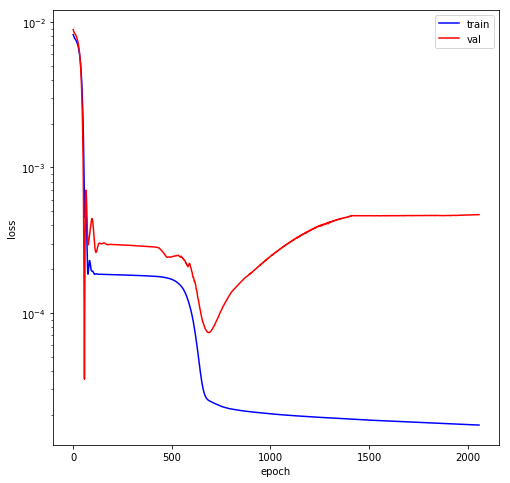

In [6]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
#plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Batch runs

#### Do a batch run to see which input parameters gives the best score

In [ ]:
total_set_size = 300000
train_size = 250000
val_size = 25000
test_size = 25000

core_input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass']
tested_input_features = ['Concentration', 'Type', 'Scale_half_mass', 
                 'Scale_last_MajM', 'Environmental_density']
output_features = ['Stellar_mass', 'SFR']
nr_extra_params_list = [2]
nr_runs_per_comb = 3

nLayers = 10
activationFunction = 'tanh'
neuronsPerLayer = 30
loss_function = 'mse' # 'mse', 'weighted_mse_1' 'mae'
norm = 'zero_to_one' # 'none',   'zero_mean_unit',   'zero_to_one'

nr_steps = 1e4
batch_size = 4e4

verb = 0 # prints progress to stdout

nr_epochs = nr_steps * batch_size / train_size
parameter_dictionary = {
    'fixed_input_features': core_input_features,
    'tested_input_features': tested_input_features,
    'output_features': output_features,
    'nr_extra_parameter_combinations': nr_extra_params_list,
    'nr_steps': [nr_steps],
    'batch_size': [batch_size],
    'nr_epochs': [nr_epochs],
    'nr_training_samples': [train_size],
    'nr_validation_samples': [val_size],
    'nr_test_samples': [test_size],
    'data_normalization': norm,
    'activation_function': activationFunction,
    'neurons_per_layer': [neuronsPerLayer],
    'nr_hidden_layers': [nLayers],
    'output_activation_function': 'none',
    'description': 'Each parameter setting is represented by one list containing three objects. The first one is ' + \
    'the input parameters. The second one is the mse test scores obtained for the different runs evaluated on the ' +\
    'normed units and the original units of the data set (original only if norm is \'none\'). The third one is the ' +\
    'loss histories for the different runs [training_loss, validation_loss] evaluated on the normalised data.'
}
results_list = [parameter_dictionary]
nr_combs_total = 0
for nr_extra_params in nr_extra_params_list:
    nr_combs_total += comb(len(tested_input_features), nr_extra_params)
comb_counter = 0 # to keep track of how many combinations I've gone through

with open('model_comparisons/progress.txt', 'w+') as f:
    
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on input parameters at ' + date_string_proper + '\n\n')
    f.flush()
    
    # load the selected galaxyfile
    galaxies, data_keys, unit_dict = load_galfile()
    
    for i_nr_extra_params, nr_extra_params in enumerate(nr_extra_params_list):
        
        extra_param_combs = list(combinations(tested_input_features, nr_extra_params))
        
        date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
        f.write(date_string_proper + '    Testing %d extra parameters. %d/%d extra parameter count tested. \n\n' %
                (nr_extra_params, i_nr_extra_params+1, len(nr_extra_params_list)))
        f.flush()
    
        for i_comb, param_comb in enumerate(extra_param_combs):
            input_features = core_input_features.copy()
            input_features.extend(param_comb)
            
            # prepare the training data
            training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, 
                                                   total_set_size, train_size, val_size, test_size)
            training_data_dict = normalise_data(training_data_dict, norm)
            
            date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
            comb_counter += 1
            f.write(date_string_proper + '        Testing combination %d/%d. \n\n' % (comb_counter, nr_combs_total))
            f.flush()
            
            original_scores = []
            if not norm == 'none':
                normed_scores = []
            histories = []

            for i_run in range(nr_runs_per_comb):

                # create model
                model = Sequential()
                model.add(Dense(neuronsPerLayer, input_dim = len(input_features), activation = activationFunction))

                for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
                    model.add(Dense(neuronsPerLayer, activation = activationFunction))

                model.add(Dense(len(output_features)))

                # Compile model
                earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=100, \
                          verbose=1, mode='auto')
                callbacks_list = [earlystop]
                model.compile(loss=loss_func_dict[loss_function], optimizer='adam')

                # Fit the model
                if norm == 'none':
                    history = model.fit(training_data_dict['x_train'], training_data_dict['y_train'], 
                                        validation_data=(training_data_dict['x_val'], training_data_dict['y_val']), 
                                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list, 
                                        verbose=verb)
                    orig_score = model.evaluate(x=training_data_dict['x_test'], y=training_data_dict['y_test'],
                                               verbose=verb)
                    original_scores.append(orig_score)
                    
                else:
                    history = model.fit(training_data_dict['x_train_norm'] , training_data_dict['y_train_norm'], 
                                        validation_data=(training_data_dict['x_val_norm'], 
                                        training_data_dict['y_val_norm']), 
                                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list, 
                                        verbose=verb)
                    norm_score = model.evaluate(x=training_data_dict['x_test_norm'], y=training_data_dict['y_test_norm'],
                                               verbose=verb)
                    normed_scores.append(norm_score)
                    orig_score = get_test_score(model, training_data_dict, norm)
                    original_scores.append(orig_score)
                    
                histories.append([history.history['loss'], history.history['val_loss']])
                
            if norm == 'none':
                scores = original_scores
            else:
                scores = [normed_scores, original_scores]
                
            results_list.append([input_features, scores, histories])
            
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark completed at ' + date_string_proper + '\n')
    f.flush()
        

#### Save the result

In [ ]:
### Save the result
date_string = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
custom_string = '5_total_inputs'
with open('model_comparisons/' + custom_string + '.json', 'w+') as f:
    json.dump(results_list, f)
f.close()

In [ ]:

#print(train_loss)
print('Lowest train/val/test loss: %.2f, %.2f, %.2f' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

#### Load a batch run result

In [ ]:
### Load a result
loaded_list_string = '5_total_inputs'
with open('model_comparisons/' + loaded_list_string + '.json', 'r') as f:
    results_list = json.load(f)
f.close()

print(results_list[0])

#### Plot the results

In [ ]:
print(len(results_list[1][1]))
print(results_list[1][1])

In [ ]:
### Plot the loss histories to make sure that the best performance was reached

for comb_nr, lst in enumerate(results_list[1:]):

    title = lst[0]
    train_loss = lst[2][0][0]
    val_loss = lst[2][0][1]
    test_loss = lst[1][0]

    #print('Lowest train/val/test loss: %.2e, %.2e, %.2e' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

    # summarize history for loss
    fig = plt.figure(5, figsize=(8,8))
    for i_run in range(len(test_loss)):
        train_loss = lst[2][i_run][0]
        val_loss = lst[2][i_run][1]
        plt.plot(train_loss, 'b')
        plt.plot(val_loss, 'r')
    plt.yscale('log')
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


In [ ]:
print(results_list[1][0])

In [ ]:
### Get the X best performing input parameters
get_normed_scores = 1
top_nr_of_parameter_combs = 10
column_widths = [0.2, 0.05]
test_results = []
val_results = []
for comb_nr, lst in enumerate(results_list[1:]):
    if get_normed_scores:
        best_test = np.amin(lst[1][0])
    else:
        best_test = np.amin(lst[1][1])
        
#    val_losses = []
#    for i_run in range(len(lst[1])):
#        val_losses.append(lst[2][i_run][1])
        
    test_results.append(best_test)
#    val_results.append(np.amin(val_losses))
    
best_test_indices = np.argsort(test_results)
#best_val_indices = np.argsort(val_results)

fig1362 = plt.figure(figsize=(16,8))

ax = plt.subplot(1,1,1)

collabel=('Input parameters', 'best test mse\n(normalised units)')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    inputs = ', '.join(results_list[best_test_indices[i]+1][0][:3])
    inputs = inputs + '\n+\n' + ', '.join(results_list[best_test_indices[i]+1][0][3:])
    
    table_vals.append([inputs, '%.3e' % 
                      (np.amin(results_list[best_test_indices[i]+1][1]))])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 4)
ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization']) +
           '\nFixed input parameters: %s' % (', '.join(results_list[0]['fixed_input_features'])), 
          fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1.15])

plt.show()

In [ ]:
fig1362.savefig(fig_dir + '5_total_inputs' + '_param_comb_scores_test.png', bbox_inches = 'tight')

In [ ]:
### Plot best validation scores
fig2 = plt.figure(figsize=(16,8))


ax = plt.subplot(1,1,1)

collabel=('Input parameters', 'best val mse\n(scaled units)')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    inputs = ', '.join(results_list[best_val_indices[i]+1][0])
    
    table_vals.append([inputs, '%.3f' % 
                      (val_results[best_val_indices[i]])])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.2, hspace=0.5)

ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, relu on output: False, 10 layers, 10 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization'], 
          ), fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1])

#plt.tight_layout(h_pad=30)

plt.show()

In [ ]:
fig2.savefig(fig_dir + '2018-05-12--13-36-02_param_comb_scores_val.png', bbox_inches = 'tight')

In [ ]:
### Find out how a parameter affects the result
collabel = ('Input parameter', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10')
first_col_width = .1
last_col_width = .02
column_widths = [first_col_width]
for i in range(10):
    column_widths.append(last_col_width)
tab_rows = []
row_colours = []

for param in results_list[0]['tested_input_features']:
    
    tab_row = [param]
    row_colour = ['w']

    for i, ind in enumerate(best_test_indices[:10]):
        inputs = results_list[ind+1][0]
        if param in inputs:
            tab_row.append('Yes')
            row_colour.append('g')
        else:
            tab_row.append('No')
            row_colour.append('r')

    tab_rows.append(tab_row)
    row_colours.append(row_colour)
        
fig8845 = plt.figure(figsize=(16,8))

ax = plt.subplot(111)

the_table = ax.table(cellText=tab_rows,colLabels=collabel,colWidths=column_widths,
                     cellColours=row_colours,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.2, hspace=0.5)
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer'
          % (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization'])+
           '\nFixed input parameters: %s\nOrdering based on test scores (normalised units)' % 
          (', '.join(results_list[0]['fixed_input_features'])), fontsize=20)
#plt.title('Ordering based on validation scores', fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 0.8])

#ax.axis('tight')
ax.axis('off')

plt.show()
    

In [ ]:
fig8845.savefig(fig_dir + '5_total_inputs' + '_param_importance_test.png', bbox_inches = 'tight')

## Plot loss history

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(train_loss, 'b')
plt.plot(val_loss, 'r')
plt.yscale('log')
plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Evaluate the model

In [ ]:
# On preprocessed data
test_loss, test_mse = model.evaluate(x_test_norm, y_test_norm, verbose=0)
print('MSE for the processed data: %.4f' % (test_mse))

In [ ]:
### Predict real value of points
if norm == 'zero_mean_unit_std':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * training_data_dict['y_data_stds'] + training_data_dict['y_data_means']
    
if norm == 'zero_to_one':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * (training_data_dict['y_data_max'] - training_data_dict['y_data_min']) + \
                        training_data_dict['y_data_min']

In [ ]:
### Get mse for the real predictions
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print('MSE for the unprocessed data: %.4f' % (total_score))

## Save a model

In [ ]:
### Save the model if it is useful
importlib.reload(model_management)
model_dictionary = {
    'training_method': 'backprop',
    'input_features': input_features,
    'output_features': output_features,
    'number_of_epochs': nEpochs,
    'batch_size': batchSize,
    'number_of_layers': nLayers,
    'neurons_per_layer': neuronsPerLayer,
    'activation_function': activationFunction,
    'train_set_size': train_size,
    'loss_function': loss_function,
    'test_loss': test_loss,
    'test_mse': test_mse,
    'preprocess_data': preprocess_data
}
description = 'First network trained on preprocessed data.'
model_management.SaveModel(model, model_dictionary, description)

In [ ]:
%matplotlib notebook
#x1 = np.linspace(np.min(x_test[:,0]), np.max(x_test[:,0]), 30)
#x2 = np.linspace(np.min(x_test[:,1]), np.max(x_test[:,1]), 30)
#X1, X2 = np.meshgrid(x1, x2)
#Z = np.zeros(X1.shape)
#for i in range(30):
#    for j in range(30):
#        Z[i, j] = model.predict(np.array([X1[i,j], X2[i,j]])) TODO varför funkar inte det här??
        
#fig = plt.figure(4)
#ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.set_zlabel('z')
        
### Old visualisation way
### Visualisation of prediction strength for when we have 2 input features
if plot_threeD and len(input_features) == 2:
    predictedY = model.predict(x_test_norm)
    predictedY = predictedY * y_data_stds + y_data_means
    fig = plt.figure(2, figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_test[:,0], x_test[:,1], 
               y_test[:,0], s=3)
    ax.scatter(x_test[:,0], x_test[:,1], 
               predictedY, s=3)
    ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[0]))
    ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[1]))
    ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[0]))

## Scatterplots and boxplots

In [ ]:
%matplotlib inline
#from pylab import plot, show, savefig, xlim, figure, \
#                hold, ylim, legend, boxplot, setp, axes
nBins = 8
halo_min_mass = np.amin(galaxies[:,6])
halo_max_mass = np.amax(galaxies[:,6])
bin_edges = np.linspace(halo_min_mass, halo_max_mass, nBins+1)

x_test = training_data_dict['x_test']
y_test = training_data_dict['y_test']

predictedY = predicted_points

for i, feat in enumerate(output_features):
    
    ### Plot 1
    fig1 = plt.figure(figsize=(8,8))
    
    plt.plot(y_test[:,i], y_test[:,i], 'k.')
    plt.plot(predictedY[:,i], y_test[:,i], 'g.')
    plt.ylabel('True %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('Predicted %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.legend(['Ideal result', 'predicted ' + feat], loc='upper center')
    #plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
    #    batchSize, train_size, test_mse) + 
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d test data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    plt.show
    
    ### Plot 2 - boxplot
    
    # bin_means contain (0: mean of the binned values, 1: bin edges, 2: numbers pointing each example to a bin)
    bin_means_true = stats.binned_statistic(x_test[:,i], y_test[:,i], bins=bin_edges)
    bin_means_pred = stats.binned_statistic(x_test[:,i], predictedY[:,i].flatten(), bins=bin_edges)
    bin_centers = []
    for iBin in range(nBins):
        bin_center = (bin_means_true[1][iBin] + bin_means_true[1][iBin+1]) / 2
        bin_centers.append('%.2f' % (bin_center))
    sorted_true_y_data = []
    sorted_pred_y_data = []
    for iBin in range(1,nBins+1):
        sorted_true_y_data.append(y_test[bin_means_true[2] == iBin, i])
        sorted_pred_y_data.append(predictedY[bin_means_pred[2] == iBin,i])
        
    fig2 = plt.figure(figsize=(16,8))
    ax = plt.subplot(111)

    bin_pos = np.array([-2,-1]) # (because this makes it work)
    x_label_centers = []
    for iBin in range(nBins):
        # Every boxplot adds 2 boxes, one from the true data and one from the predicted data
        bin_pos += 3 
        plt.boxplot([sorted_true_y_data[iBin], sorted_pred_y_data[iBin]] , positions = bin_pos, widths = 0.9)
        x_label_centers.append(np.mean(bin_pos))
    
    plt.ylabel('%s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('True Halo mass log($M_{G}/M_{S}$)', fontsize=15)
    ax.set_xlim(left=x_label_centers[0]-2, right=x_label_centers[-1]+2)
    #xlim(0,bin_pos[1] + 1)
    plt.xticks(x_label_centers, bin_centers)
    #plt.text(12,7,'Left: true data. Right: predicted data.', fontsize=20)
    
    if feat == 'SFR':
        ax.axhline(y=0, linestyle='--')
    
    #plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
    #    batchSize, train_size, test_mse) + 
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d test data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    
    plt.show()        

In [ ]:
fig1.savefig(fig_dir+'bp_output_scatter_%d_plot_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')
fig2.savefig(fig_dir+'bp_output_boxplot_%d_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')

## Scatterplots and plots with errorbars

In [ ]:
### Predict real value of points
if norm == 'zero_mean_unit_std':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * training_data_dict['y_data_stds'] + training_data_dict['y_data_means']
    
if norm == 'zero_to_one':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * (training_data_dict['y_data_max'] - training_data_dict['y_data_min']) + \
                        training_data_dict['y_data_min']

In [ ]:
%matplotlib inline
#from pylab import plot, show, savefig, xlim, figure, \
#                hold, ylim, legend, boxplot, setp, axes
nBins = 8
halo_min_mass = np.amin(galaxies[:,6])
halo_max_mass = np.amax(galaxies[:,6])
bin_edges = np.linspace(halo_min_mass, halo_max_mass, nBins+1)

x_test = training_data_dict['x_test']
y_test = training_data_dict['y_test']

predictedY = predicted_points

for i, feat in enumerate(output_features):
    
    
    ### Plot 1
    fig1 = plt.figure(figsize=(8,8))
    
    plt.plot(y_test[:,i], y_test[:,i], 'k.')
    plt.plot(predictedY[:,i], y_test[:,i], 'g.')
    plt.ylabel('True %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('Predicted %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.legend(['Ideal result', 'predicted ' + feat], loc='upper center')
    #plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
    #    batchSize, train_size, test_mse) + 'loss function: %s\n' % (loss_function) +
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    plt.show
    
    ### Plot 2 - Spread of the distribution
    
    # bin_means contain (0: mean of the binned values, 1: bin edges, 2: numbers pointing each example to a bin)
    bin_means_true = stats.binned_statistic(x_test[:,0], y_test[:,i], bins=bin_edges)
    bin_means_pred = stats.binned_statistic(x_test[:,0], predictedY[:,i].flatten(), bins=bin_edges)

    bin_centers = []
    for iBin in range(nBins):
        bin_center = (bin_means_true[1][iBin] + bin_means_true[1][iBin+1]) / 2
        bin_centers.append('%.2f' % (bin_center))
    sorted_true_y_data = []
    sorted_pred_y_data = []
    for iBin in range(1,nBins+1):
        sorted_true_y_data.append(y_test[bin_means_true[2] == iBin, i])
        sorted_pred_y_data.append(predictedY[bin_means_pred[2] == iBin,i])
    
    # get standard deviations of the binned values
    stds_true = np.zeros((nBins))
    stds_pred = np.zeros((nBins))
    for iBin in range(nBins):
        stds_true[iBin] = np.std(sorted_true_y_data[iBin])
        stds_pred[iBin] = np.std(sorted_pred_y_data[iBin])
        
    fig2 = plt.figure(figsize=(16,8))
    ax = plt.subplot(111)

    bin_pos = np.array([-2,-1]) # (because this makes it work)
    x_label_centers = []
    for iBin in range(nBins):
        # Every plot adds 2 distributions, one from the true data and one from the predicted data
        bin_pos += 3 
        plt.errorbar(bin_pos[0], bin_means_true[0][iBin], yerr=stds_true[iBin], fmt = 'bo', capsize=5)
        plt.errorbar(bin_pos[1], bin_means_pred[0][iBin], yerr=stds_pred[iBin], fmt = 'ro', capsize=5)
        x_label_centers.append(np.mean(bin_pos))
    
    plt.ylabel('%s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('True Halo mass log($M_{G}/M_{S}$)', fontsize=15)
    plt.legend(['True data $\pm 1 \sigma$', 'Predicted data $\pm 1 \sigma$'], loc='upper left', fontsize='xx-large')
    ax.set_xlim(left=x_label_centers[0]-2, right=x_label_centers[-1]+2)
    #xlim(0,bin_pos[1] + 1)
    plt.xticks(x_label_centers, bin_centers)
    
    #plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
    #    batchSize, train_size, test_mse) + 'loss function: %s\n' % (loss_function) +
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    
    plt.show()

In [ ]:
fig1.savefig(fig_dir+'bp_output_scatter_%d_plot_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')
fig2.savefig(fig_dir+'bp_output_boxplot_%d_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')

In [ ]:
#print(predictedY.flatten())
#bin_means = stats.binned_statistic(predictedY.flatten(), y_test[:,0], bins=10)
#bin_stds = stats.binned_statistic(predictedY.flatten(), y_test[:,0], bins=10, statistic=GetSTD)
#print(bin_means[0])
#print(bin_stds[0])

## Plot SFR vs Stellar mass

In [ ]:
### Save the figure
fig.savefig(fig_dir+'bp_sfr_to_stellar_mass_inputs_' + '_and_'.join(input_features)+
            '_with_'+param_string+'.png', bbox_inches = 'tight')

### Check to see how the MSE is calculated 

In [ ]:
predicted_points = model.predict(x_test)
print(np.shape(predicted_points))
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print(total_score)

keras_scores = model.evaluate(x_test, y_test, verbose=0)
print(keras_scores)

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Testing functions

In [ ]:
### TESTING
coordinates = galaxies[:1000, :3]
halo_masses = np.power(10, galaxies[:1000, 6])
nr_points = np.shape(coordinates)[0]

nr_neighbours_wanted = 30
box_sides = np.array([200, 200, 200])

neigh_densities = get_density_periodic(coordinates, halo_masses, nr_neighbours_wanted, 
                                                                 box_sides, nr_points, verbatim=True)
print(neigh_densities)